## Introduction

Ce projet explore différentes approches de prévision pour anticiper la consommation électrique du réseau national britannique. En exploitant les données historiques du National Grid ESO (2009-2024), nous comparons systématiquement plusieurs algorithmes de pointe en intelligence artificielle.

### Phase 1 : Préparation des Données

* Analyse exploratoire et nettoyage des données
* Ingénierie des caractéristiques temporelles
* Détection des tendances et cycles saisonnie
* Intégration des jours fériés britanniques

### Phase 2 : Implémentation des Modèles

* XGBoost : Algorithme de boosting performant pour les séries temporelles
* Arbres Linéaires : Approche hybride innovante combinant arbres et modèles linéaires
* Prophet : Solution spécialisée de Meta pour les séries temporelles
* LSTM : Réseaux neuronaux récurrents avec mécanisme de mémoire
* LSTM Profonds : Architectures multi-couches pour une modélisation avancée
* GRU (Gated Recurrent Unit)

In [1]:
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree
!pip install tensorflow keras
!pip install tensorflow pmdarima prophet linear-tree holidays seaborn statsmodels scikit-learn xgboost
!pip install workalendar

In [2]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

#### Quelque paramètres par défaut de la figure

In [4]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

### Importer les données

In [6]:
df = pd.read_csv("C:\\Users\\abdoo\\OneDrive\\Documents\\CI2\\S3\\deep learning\\Projet\\historic_demand_2009_2024.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [7]:
df.drop(columns=["scottish_transfer", "viking_flow","greenlink_flow"], axis=1, inplace=True)

### Feature engineering

Dans cette section, je présenterai les différentes étapes permettant d’analyser et de transformer le jeu de données initial. Les étapes suivies sont les suivantes :

* Analyse exploratoire : obtenir un premier aperçu du jeu de données temporelles.
* Préparation des données : gérer les valeurs manquantes, éliminer les variables non pertinentes et détecter les valeurs aberrantes.
* Analyse des caractéristiques : étudier la tendance générale ainsi que les différentes formes de saisonnalité présentes dans les données.

### Compréhension des données

L’ensemble de données fournit une description complète de toutes les colonnes, mais dans le cadre de ce projet, seules trois d’entre elles seront utilisées :

* DATE DE RÈGLEMENT : date au format jj/mm/aaaa.

* PÉRIODE_RÈGLEMENT : intervalle de trente minutes correspondant à l’événement historique observé.

* Demande du Réseau de Transport (DRT) : correspond à la demande nominale (DN) additionnée de la production supplémentaire nécessaire pour couvrir la     consommation des centrales, le pompage des stations de stockage ainsi que les exportations via les interconnexions. Cette valeur est exprimée en MW, qui est notre variable cible à prédire.


Passons maintenant à un aperçu global du jeu de données et de ses statistiques.



In [11]:
df.sample(n=7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
66011       2012-10-07                  6  24127  26019                 21951   
98784       2014-08-20                 21  35334  36287                 32079   
146123      2017-05-03                 12  23441  25274                 21171   
221734      2021-08-25                 15  26684  27275                 24142   
19887       2010-02-19                 16  42866  45965                 38335   
34207       2010-12-14                 32  52325  55072                 47285   
166444      2018-06-30                 31  20851  21933                 18646   

        embedded_wind_generation  embedded_wind_capacity  \
66011                        155                    2085   
98784                        414                    3344   
146123                      1272                    5108   
221734                       527                    6527   
19887                        596                    1824   
34207                        435                    2141   
166444                      1575                    5913   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
66011                           0                     1922            0   
98784                        2550                     5162            0   
146123                         21                    12000            0   
221734                        460                    13080            0   
19887                           0                        0            0   
34207                           1                       73            0   
166444                       8050                    13052            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
66011                   1141       992          0           993        -251   
98784                     12      1996          0          1000           0   
146123                  1333       312          0           781         232   
221734                    28      2001        990          1028         -62   
19887                      7     -2047          0             0        -445   
34207                      3     -1743          0             0        -401   
166444                     3      1701          0           331        -415   

        east_west_flow  nemo_flow  nsl_flow  eleclink_flow  is_holiday  
66011                0          0       NaN            NaN           0  
98784             -441          0       NaN            NaN           0  
146123               0          0       NaN            NaN           0  
221734               0        997      -1.0            0.0           0  
19887                0          0       NaN            NaN           0  
34207                0          0       NaN            NaN           0  
166444            -164          0       NaN            NaN           0

In [12]:
df.describe()

settlement_period             nd            tsd  england_wales_demand  \
count      279264.000000  279264.000000  279264.000000         279264.000000   
mean           24.500229   31186.565042   32627.843779          28389.002868   
std            13.853821    7827.270027    7710.008440           7087.628201   
min             1.000000   13367.000000       0.000000              0.000000   
25%            12.750000   24908.000000   26582.000000          22677.000000   
50%            24.500000   30495.000000   31782.000000          27756.000000   
75%            36.250000   36913.000000   38096.000000          33615.000000   
max            50.000000   59095.000000   60147.000000          53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             279264.000000           279264.000000   
mean                1270.098774             4447.695772   
std                  966.304596             1957.216235   
min                    0.000000             1403.000000   
25%                  551.000000             2102.000000   
50%                 1016.000000             4831.000000   
75%                 1726.000000             6527.000000   
max                 5930.000000             6622.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              279264.000000            279264.000000  279264.000000   
mean                  878.177069              8685.163430       6.654220   
std                  1709.142408              5875.188186      39.150778   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              2028.000000       0.000000   
50%                     0.000000             11503.000000       0.000000   
75%                   883.000000             13080.000000       0.000000   
max                 11224.000000             17197.000000     893.000000   

       pump_storage_pumping       ifa_flow      ifa2_flow   britned_flow  \
count         279264.000000  279264.000000  279264.000000  279264.000000   
mean             304.734674     926.205544      53.852140     503.999842   
std              528.372063    1067.861437     353.722565     541.490053   
min                0.000000   -2056.000000   -1030.000000   -1215.000000   
25%                8.000000     273.000000       0.000000       0.000000   
50%               11.000000    1178.000000       0.000000     725.000000   
75%              368.000000    1891.000000       0.000000     994.000000   
max             2019.000000    2066.000000    1016.000000    1143.000000   

          moyle_flow  east_west_flow      nemo_flow       nsl_flow  \
count  279264.000000   279264.000000  279264.000000  103968.000000   
mean     -125.610222      -50.967919     175.876626     416.582977   
std       230.333166      262.941668     421.668169     650.866003   
min      -505.000000     -585.000000   -1023.000000   -1455.000000   
25%      -304.000000     -208.000000       0.000000       0.000000   
50%      -149.000000        0.000000       0.000000       0.000000   
75%        24.000000        0.000000     332.000000    1095.000000   
max       499.000000      504.000000    1033.000000    1401.000000   

       eleclink_flow     is_holiday  
count  103968.000000  279264.000000  
mean      114.173929       0.022516  
std       490.431568       0.148356  
min     -1028.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%        75.000000       0.000000  
max      1002.000000       1.000000

In [13]:
df.shape

(279264, 20)

Trions les valeurs par date, car certaines ont été mal placées dans l'ensemble de données d'origine.



In [15]:
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

### Préparation des données
L’objectif de cette section est de préparer les données avant l’entraînement du modèle. Pour cela, je procéderai aux étapes suivantes :

* Identifier le nombre de valeurs manquantes et supprimer les colonnes qui en contiennent trop.
* Éliminer les lignes dont la valeur de settlement_period dépasse 48, car l’API précise qu’un jour ne comporte au maximum que 48 intervalles.
* Retirer les valeurs aberrantes.

Ajouter une nouvelle caractéristique : les jours fériés au Royaume-Uni. Je l’intègre dès maintenant, avant de transformer le format des dates, ce qui simplifiera l’analyse ultérieure.

Commençons par vérifier la présence éventuelle de valeurs manquantes :

In [17]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
dtype: bool

Comme on peut le constater, seules deux colonnes contiennent des valeurs nan. Vérifions combien de nanvaleurs contient chaque colonne :

In [19]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

nsl_flow  eleclink_flow
True     175296         175296
False    103968         103968

Il semble que les deux variables aient le même nombre des valeurs nan. Examinons le dataframe contenant ces nan valeurs :

In [21]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
0           2009-01-01                  1  37910  38704                 33939   
1           2009-01-01                  2  38047  38964                 34072   
2           2009-01-01                  3  37380  38651                 33615   
3           2009-01-01                  4  36426  37775                 32526   
4           2009-01-01                  5  35687  37298                 31877   
...                ...                ...    ...    ...                   ...   
175291      2018-12-31                 44  26826  28428                 25195   
175292      2018-12-31                 45  25660  27542                 24145   
175293      2018-12-31                 46  25047  26971                 23496   
175294      2018-12-31                 47  24188  26224                 22683   
175295      2018-12-31                 48  23800  25785                 22367   

        embedded_wind_generation  embedded_wind_capacity  \
0                             54                    1403   
1                             53                    1403   
2                             53                    1403   
3                             50                    1403   
4                             50                    1403   
...                          ...                     ...   
175291                      2734                    5918   
175292                      2730                    5918   
175293                      2726                    5918   
175294                      2673                    5918   
175295                      2620                    5918   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                               0                        0            0   
1                               0                        0            0   
2                               0                        0            0   
3                               0                        0            0   
4                               0                        0            0   
...                           ...                      ...          ...   
175291                          0                    13052            0   
175292                          0                    13052            0   
175293                          0                    13052            0   
175294                          0                    13052            0   
175295                          0                    13052            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
0                         33      2002          0             0        -161   
1                        157      2002          0             0        -160   
2                        511      2002          0             0        -160   
3                        589      1772          0             0        -160   
4                        851      1753          0             0        -160   
...                      ...       ...        ...           ...         ...   
175291                    13      1960          0           777        -454   
175292                    23      1182          0          -268        -455   
175293                    36      1157          0          -297        -455   
175294                    49      1546          0          -467        -454   
175295                    97      1553          0          -453        -454   

        east_west_flow  nemo_flow  nsl_flow  eleclink_flow  is_holiday  
0                    0          0       NaN            NaN           1  
1                    0          0       NaN            NaN           1  
2                    0          0       NaN            NaN           1  
3                    0          0       NaN            NaN           1  
4                    0          0       NaN            NaN           1  
...                ...   

Il semble que ces deux fonctionnalités n’aient pas été présentes entre 2009 et 2018. Il est donc préférable de les supprimer.

Par ailleurs, j’éliminerai également les lignes dont la valeur settlement_period dépasse 48, puisque 48 représente le nombre maximal d’intervalles par jour. Toute valeur supérieure correspond donc à une erreur dans les données.



In [23]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

### Jours fériés

Les jours fériés sont essentiels pour les prévisions de séries temporelles, car ils influencent souvent les valeurs des données ces jours-là. C'est pourquoi je souhaite ajouter une colonne à mon jeu de données pour indiquer si chaque jour était férié ou non.

Étant donné que l'ensemble de données couvre la demande d'électricité pour l'Angleterre et le Pays de Galles, la première étape consiste à vérifier que les deux pays ont les mêmes jours fériés :

In [25]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [26]:
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)

    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25')]

Une fois que j'ai vérifié que les jours fériés sont correctement chargés, on peut comparer la holiday_dates variable et la date dans l'ensemble de données et stocker le résultat booléen dans une nouvelle colonne :

In [28]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

settlement_date  settlement_period     nd    tsd  england_wales_demand  \
81497       2013-08-26                  4  21975  24006                 19858   
262580      2023-12-25                  3  18953  23061                 17619   
92946       2014-04-21                 31  28717  29859                 26055   
116812      2015-08-31                 43  32198  33292                 29018   
214745      2021-04-02                 20  28203  29035                 25246   
164859      2018-05-28                 48  23228  23780                 20809   
210174      2020-12-28                  7  23503  24818                 21328   

        embedded_wind_generation  embedded_wind_capacity  \
81497                        239                    2313   
262580                      2962                    6488   
92946                        980                    2524   
116812                       664                    3977   
214745                      1521                    6527   
164859                      1052                    5859   
210174                       802                    6527   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
81497                           0                     2933            0   
262580                          0                    15905            0   
92946                        2420                     4610            0   
116812                          0                     8841            0   
214745                       2880                    13080            0   
164859                          0                    13052            0   
210174                          0                    13080            0   

        pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  moyle_flow  \
81497                   1282      1291          0           805           0   
262580                  1514       125         -4           223         -31   
92946                     12      1999          0           998        -173   
116812                    16      1964          0           984        -189   
214745                     5      2002        993             0        -317   
164859                    52      1700          0           853         174   
210174                   713      1706         -2             0         301   

        east_west_flow  nemo_flow  is_holiday  
81497             -249          0           1  
262580            -505        429           1  
92946             -457          0           1  
116812            -389          0           1  
214745             -10        999           1  
164859             494          0           1  
210174             504        854           1

L’exemple de dataframe présenté ci-dessus confirme que la nouvelle colonne a bien été ajoutée. Nous pouvons désormais analyser plus facilement les jours fériés à l’aide d’un graphique.



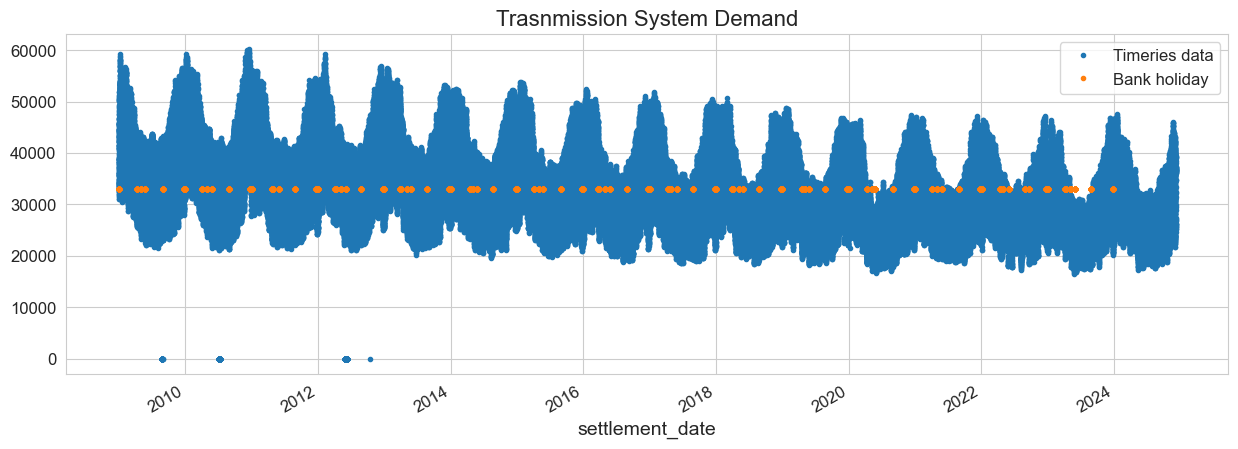

In [30]:
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

Ce graphique permet d’observer clairement l’évolution de la série temporelle : on y voit une tendance globale à la baisse ainsi qu’une saisonnalité annuelle marquée. Il met également en évidence la présence de valeurs égales à 0, qui seront supprimées dans la section suivante.

Avant d’examiner les valeurs aberrantes, notons que ce graphique révèle bien la tendance annuelle, mais ne permet pas d’analyser les variations quotidiennes ou hebdomadaires. Pour cela, construisons un second graphique focalisé sur une seule semaine :



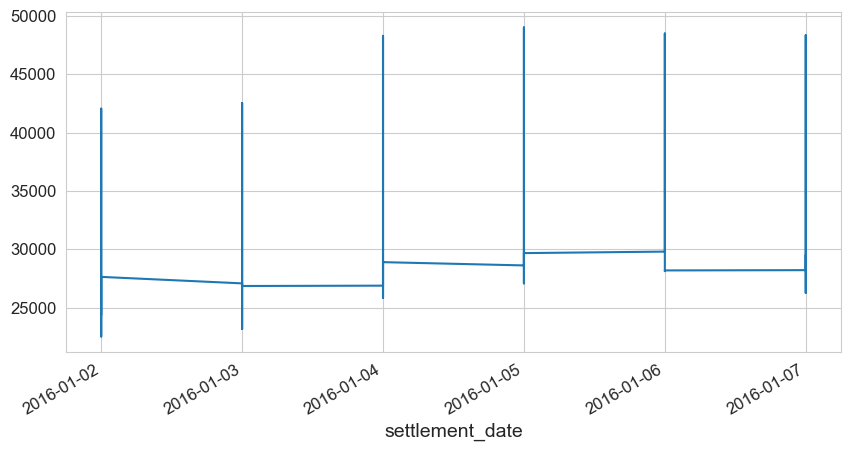

In [32]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

Ce graphique ne correspond pas à ce que j'attendais… Est-ce que je représente le bon paramètre ou y a-t-il un problème dans les données ? On peut commencer par examiner le dataframe :

En définissant uniquement la date comme index, j’ai omis d’y intégrer l’heure. Résultat : les 48 échantillons journaliers se superposent.

Avant de poursuivre, deux actions s’imposent :

* Supprimer les valeurs aberrantes.
* Ajouter l’heure à la date, puis définir cette nouvelle colonne comme index.

### Analyse des valeurs aberrantes

Je supprimerai non seulement les valeurs égales à 0, mais aussi l’ensemble des données des journées où ces valeurs apparaissent. En effet, conserver les autres observations de ces journées rendrait les données journalières non représentatives.

In [35]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

La première étape pour créer cette fonctionnalité consiste à ajuster le format de la date afin d’y intégrer l’information horaire. Les valeurs de settlement_period indiquent le numéro de l’échantillon dans la journée. Comme il existe 48 échantillons par jour, chaque échantillon correspond à un intervalle de 30 minutes.



In [37]:
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

settlement_date  settlement_period period_hour     nd    tsd  \
277414      2024-11-13                  7     3:00:00  22880  25939   
273355      2024-08-20                 28    13:30:00  19560  22060   
242563      2022-11-17                 48    23:30:00  22089  27275   
167144      2018-07-30                 29    14:00:00  29066  29588   
210648      2021-01-22                  1     0:00:00  26014  27383   
121075      2015-12-13                 34    16:30:00  44963  45561   
82207       2013-09-24                 42    20:30:00  39555  40315   

        england_wales_demand  embedded_wind_generation  \
277414                 20883                      1004   
273355                 18140                      3935   
242563                 20432                      2814   
167144                 26631                      1941   
210648                 24325                      2435   
121075                 40335                       752   
82207                  35842                       110   

        embedded_wind_capacity  embedded_solar_generation  \
277414                    6622                          0   
273355                    6622                       9268   
242563                    6545                          0   
167144                    5913                       4520   
210648                    6527                          0   
121075                    4013                          0   
82207                     2337                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
277414                    17194            0                   817      2006   
273355                    17193            0                   587      1371   
242563                    13861            0                   485     -1028   
167144                    13052          102                    11      1728   
210648                    13080            0                   586      1605   
121075                     9063          173                    17      1497   
82207                      2994            2                    11      1989   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
277414        489          -404        -452            -485        436   
273355        605          -807        -447            -159        408   
242563      -1029             0         248               0      -1020   
167144          0          1001        -113               0          0   
210648         -3             0        -107             -73        805   
121075          0          1006           0            -154          0   
82207           0          1000        -251               0          0   

        is_holiday  
277414           0  
273355           0  
242563           0  
167144           0  
210648           0  
121075           0  
82207            0

Comme on peut le constater, une nouvelle colonne indique period_hour l'heure à laquelle la mesure de la demande en électricité a été effectuée. On peut maintenant la combiner avec la date



In [39]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

settlement_date  settlement_period period_hour     nd    tsd  \
269772 2024-06-06 22:00:00                 45    22:00:00  25512  29119   
229237 2022-02-13 07:30:00                 16     7:30:00  24089  25271   
106282 2015-02-08 11:00:00                 23    11:00:00  37933  38956   
81445  2013-09-08 23:30:00                 48    23:30:00  24672  25731   
217314 2021-06-09 22:00:00                 45    22:00:00  27474  28131   

        england_wales_demand  embedded_wind_generation  \
269772                 23491                      1116   
229237                 21680                      2556   
106282                 34602                       926   
81445                  22209                       182   
217314                 25180                      1547   

        embedded_wind_capacity  embedded_solar_generation  \
269772                    6562                          0   
229237                    6527                          5   
106282                    4077                       2750   
81445                     2486                          0   
217314                    6527                          0   

        embedded_solar_capacity  non_bm_stor  pump_storage_pumping  ifa_flow  \
269772                    17193            0                     1      2007   
229237                    13708            0                   259       380   
106282                     6725            0                    11      1496   
81445                      2958            0                   168      1993   
217314                    13080            0                     9      1313   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
269772        992          -883        -451            -527       -346   
229237        466             0        -303             -20        999   
106282          0           983         -57            -355          0   
81445           0           959           0            -391          0   
217314        795           699        -148               0        808   

        is_holiday  
269772           0  
229237           0  
106282           0  
81445            0  
217314           0

La seconde étape consiste à ajouter des décalages temporels.

In [41]:
def prepare_datetime_index(df):
    """
    Convertir les colonnes de date en index datetime
    """
    # Vérifier quelles colonnes de date existent
    date_columns = ['settlement_date', 'date', 'timestamp']  # Essayer différents noms possibles
    
    for col in date_columns:
        if col in df.columns:
            print(f"✅ Utilisation de la colonne '{col}' comme index datetime")
            # Convertir en datetime et mettre en index
            df[col] = pd.to_datetime(df[col], errors='coerce')
            df = df.set_index(col)
            return df
    
    # Si aucune colonne de date trouvée, utiliser l'index actuel
    print("⚠️ Aucune colonne de date trouvée, vérification de l'index...")
    return df

def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    
    # Vérifier si l'index est déjà datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        print("❌ L'index n'est pas datetime, conversion nécessaire...")
        df = prepare_datetime_index(df)
    
    # Maintenant créer les features
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    df["hour"] = df.index.hour if hasattr(df.index, 'hour') else 0
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    
    print("✅ Features temporelles créées avec succès")
    return df

def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.
    """
    # Vérifier si l'index est datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        print("❌ Impossible d'ajouter les lags sans index datetime")
        return df
    
    target_map = df["tsd"].to_dict()
    
    # 364 est choisi au lieu de 365 car divisible par 4
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    
    print("✅ Lags ajoutés avec succès")
    return df

# ✅ EXÉCUTION DE TES DEUX FONCTIONS
print("🔄 Début du traitement des features...")

df = create_features(df)
df = add_lags(df)

print("\n🎉 Traitement terminé !")
print("📊 Aperçu des données avec nouvelles features:")
df.sample(n=5)

🔄 Début du traitement des features...
❌ L'index n'est pas datetime, conversion nécessaire...
✅ Utilisation de la colonne 'settlement_date' comme index datetime
✅ Features temporelles créées avec succès
✅ Lags ajoutés avec succès

🎉 Traitement terminé !
📊 Aperçu des données avec nouvelles features:


settlement_period period_hour     nd    tsd  \
settlement_date                                                    
2019-08-23 21:30:00                 44    21:30:00  28112  29054   
2023-11-22 18:00:00                 37    18:00:00  36973  39219   
2012-10-19 03:30:00                  8     3:30:00  25804  27864   
2017-07-13 08:00:00                 17     8:00:00  30936  31444   
2020-11-16 17:00:00                 35    17:00:00  40665  41291   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2019-08-23 21:30:00                 25676                      1190   
2023-11-22 18:00:00                 35031                      3278   
2012-10-19 03:30:00                 23199                       149   
2017-07-13 08:00:00                 28138                       604   
2020-11-16 17:00:00                 37189                      2170   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2019-08-23 21:30:00                    6182                          0   
2023-11-22 18:00:00                    6488                          0   
2012-10-19 03:30:00                    2085                          0   
2017-07-13 08:00:00                    5305                       1870   
2020-11-16 17:00:00                    6527                          0   

                     embedded_solar_capacity  non_bm_stor  ...  day_of_year  \
settlement_date                                            ...                
2019-08-23 21:30:00                    13080            0  ...          235   
2023-11-22 18:00:00                    15954            0  ...          326   
2012-10-19 03:30:00                     1948            0  ...          293   
2017-07-13 08:00:00                    12372            0  ...          194   
2020-11-16 17:00:00                    13080            0  ...          321   

                     quarter  month  year  week_of_year  hour  is_weekend  \
settlement_date                                                             
2019-08-23 21:30:00        3      8  2019            34    21           0   
2023-11-22 18:00:00        4     11  2023            47    18           0   
2012-10-19 03:30:00        4     10  2012            42     3           0   
2017-07-13 08:00:00        3      7  2017            28     8           0   
2020-11-16 17:00:00        4     11  2020            47    17           0   

                        lag1     lag2     lag3  
settlement_date                                 
2019-08-23 21:30:00  29002.0  30725.0  31523.0  
2023-11-22 18:00:00  41310.0  43085.0  43725.0  
2012-10-19 03:30:00  29943.0  31387.0  30171.0  
2017-07-13 08:00:00  31726.0  34589.0  36150.0  
2020-11-16 17:00:00  45785.0  45948.0  47057.0  

[5 rows x 30 columns]

### Compréhension des fonctionnalités

Dans cette section, j’examinerai la répartition de la demande en électricité selon plusieurs critères, notamment l’heure, le mois et l’année. Cette analyse est un moyen efficace de mettre en évidence les variations saisonnières propres aux séries temporelles.

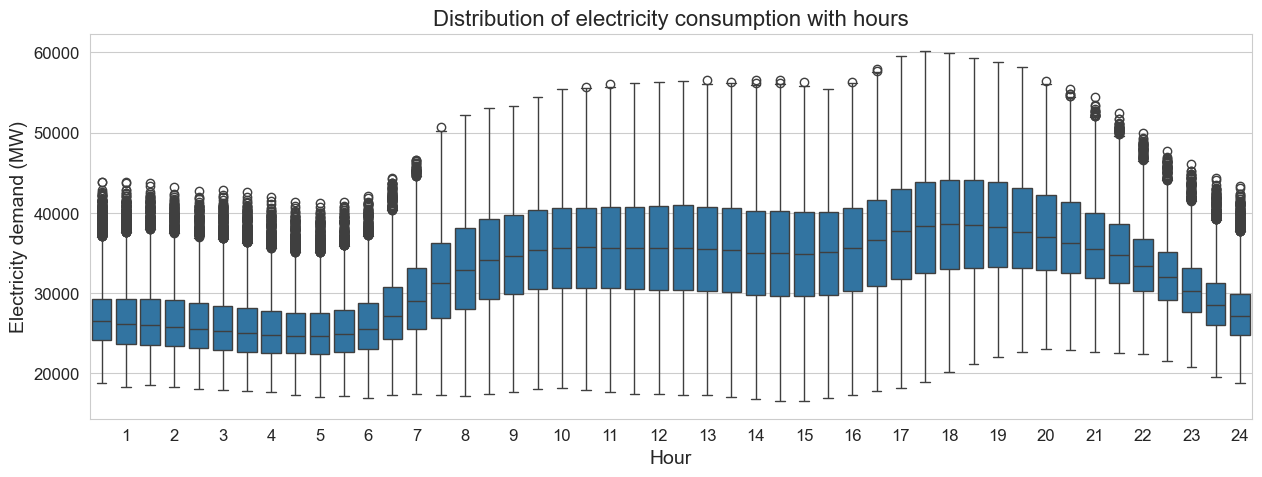

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

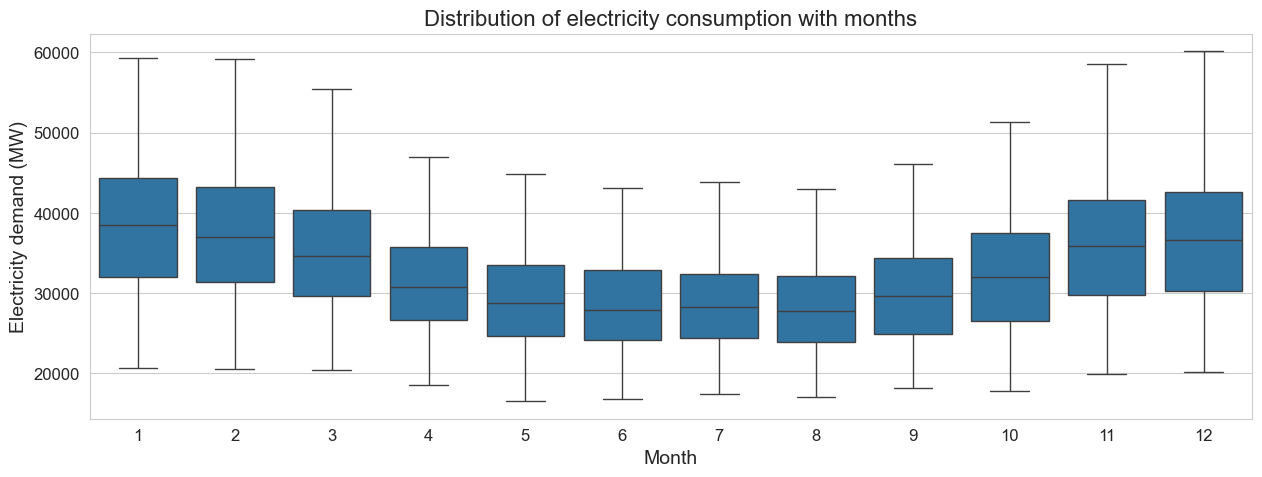

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

Il semble que la consommation la plus faible soit enregistrée pendant les mois d’été. Ayant grandi à Djibouti, cela me surprend, car l’utilisation massive de la climatisation augmente généralement la demande en électricité.

Traçons maintenant un graphique pour une année précise, par exemple 2016, afin de vérifier que la variable utilisée dans le graphique précédent est bien la bonne.



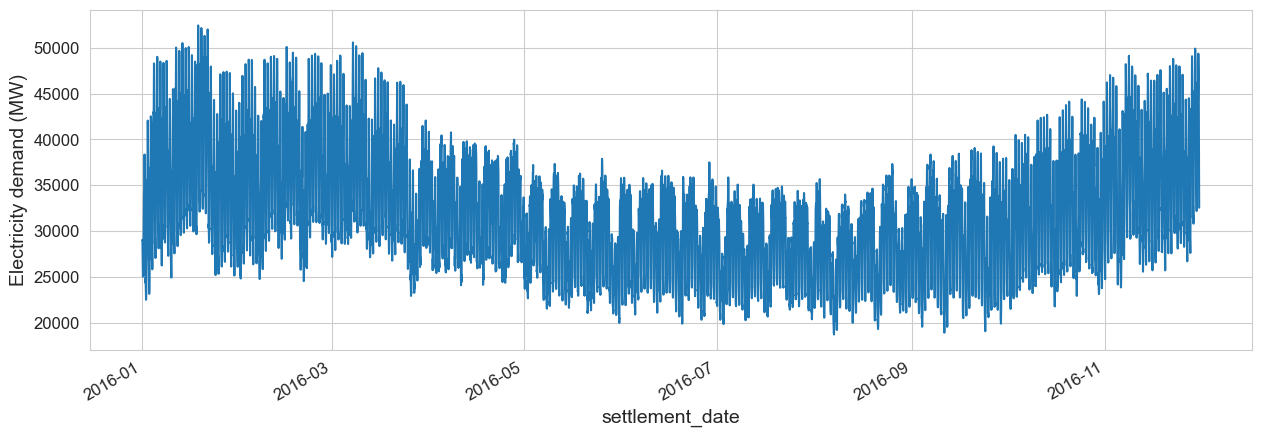

In [46]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

Ce graphique confirme les résultats du graphique précédent.

Examinons l'effet des jours fériés sur la consommation d'électricité :

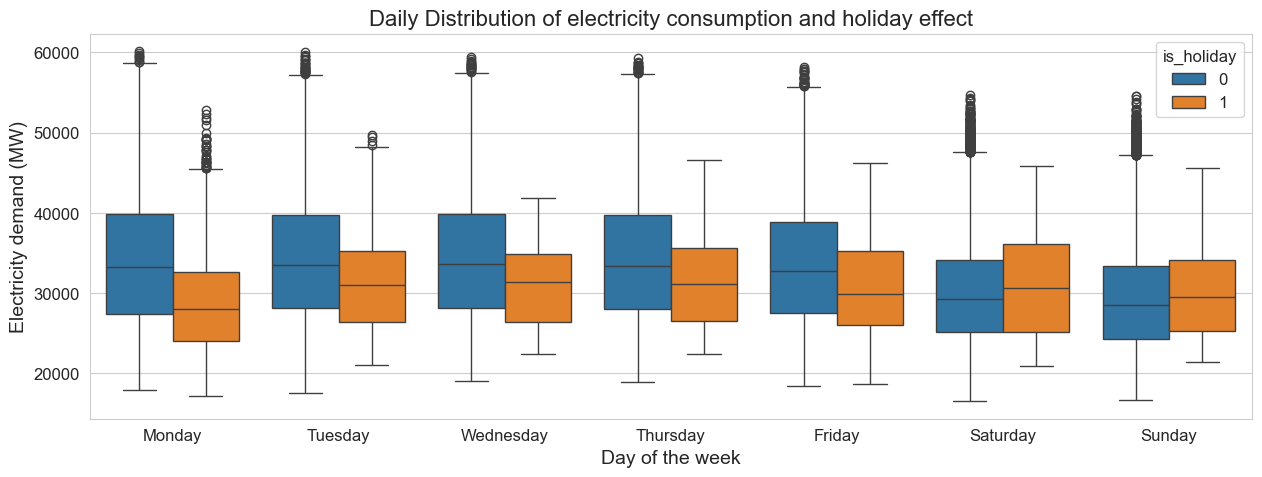

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

# ✅ CORRECTION : Utiliser set_xticks() avant set_xticklabels()
ax.set_xticks(range(7))  # 7 jours de la semaine
ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect")
plt.show()

Il apparaît que, du lundi au vendredi, la consommation d’électricité est en moyenne plus faible les jours fériés, tandis qu’elle augmente le samedi et reste similaire le dimanche.

Pour les jours non fériés, on observe que la demande du week-end est inférieure à celle des jours de semaine.



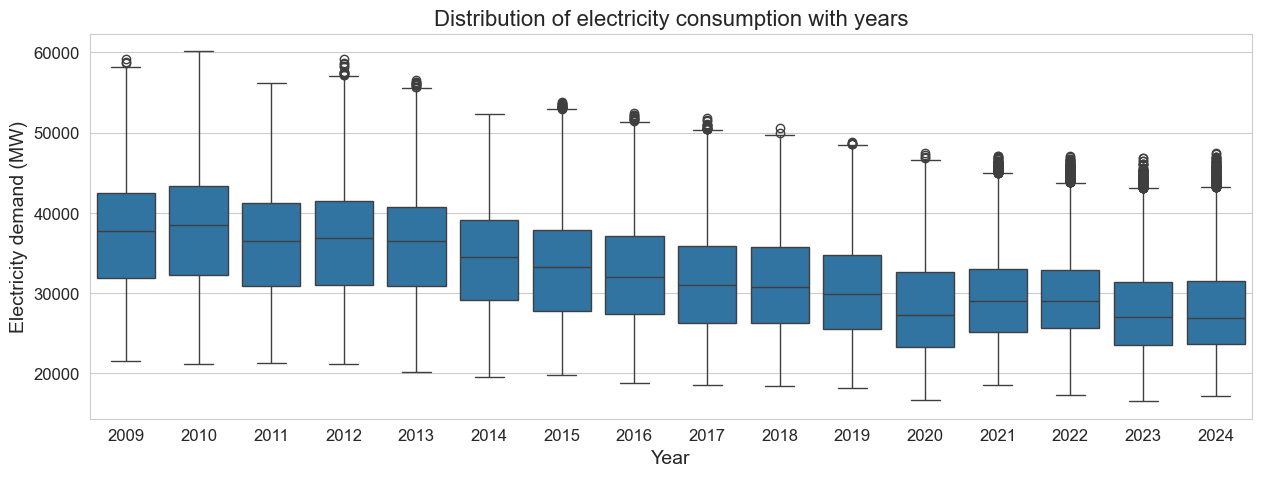

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Bien qu'il s'agisse de valeurs moyennes annuelles, on observe une tendance à la baisse de la consommation d'électricité. On peut superposer la consommation d'électricité sur deux ans pour la comparer :



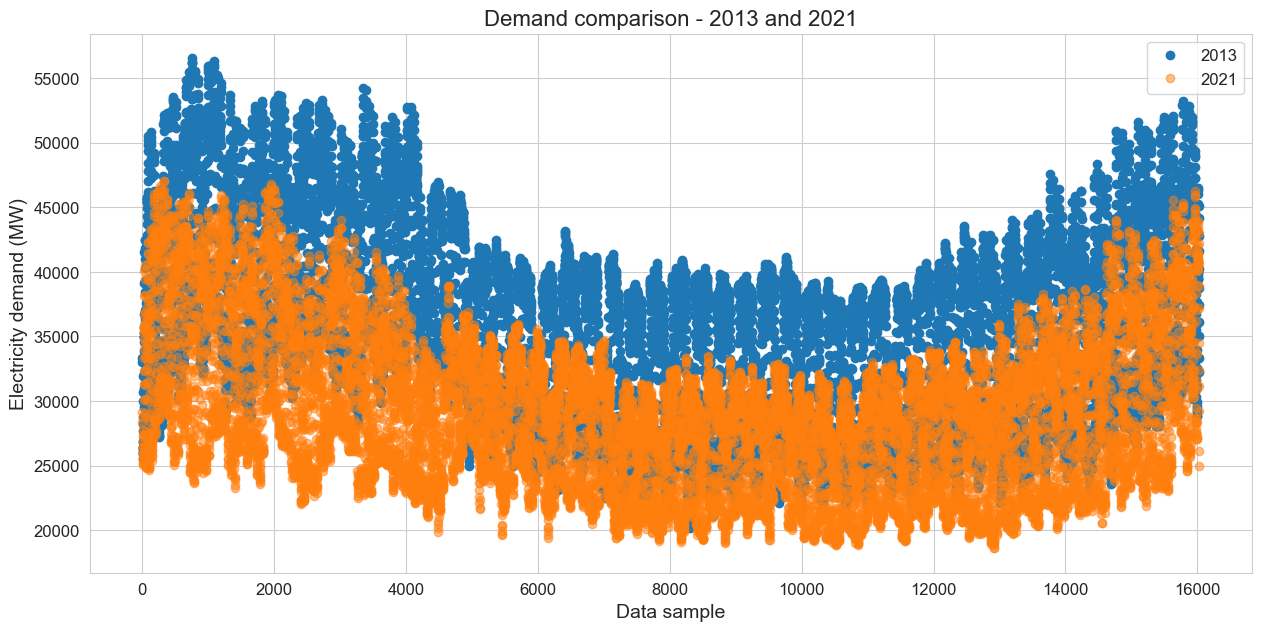

In [52]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

Ce graphique confirme une fois de plus que la consommation d'électricité est en baisse ces dernières années.



## Modèles à implémenter


Une fois que j'aurai suffisamment compris les données de séries temporelles, je serai prêt à créer différents modèles et à vérifier leur précision. Afin de comparer les résultats des modèles, j'utiliserai l'erreur moyenne absolue en pourcentage (MAER).

In [55]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

## Modèle XGBoost simple

Le premier modèle XGBoost est une version simple avec quelques paramètres prédéfinis et une séparation classique entre les données d’entraînement et de test. Bien qu’il soit basique, il constitue un excellent point de référence.

### Training - test split


La première étape consiste à diviser les données. Je les diviserai en un ensemble d'entraînement, un ensemble de test et un ensemble de validation. Ce dernier servira à évaluer le modèle indépendamment pendant son entraînement.



In [59]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

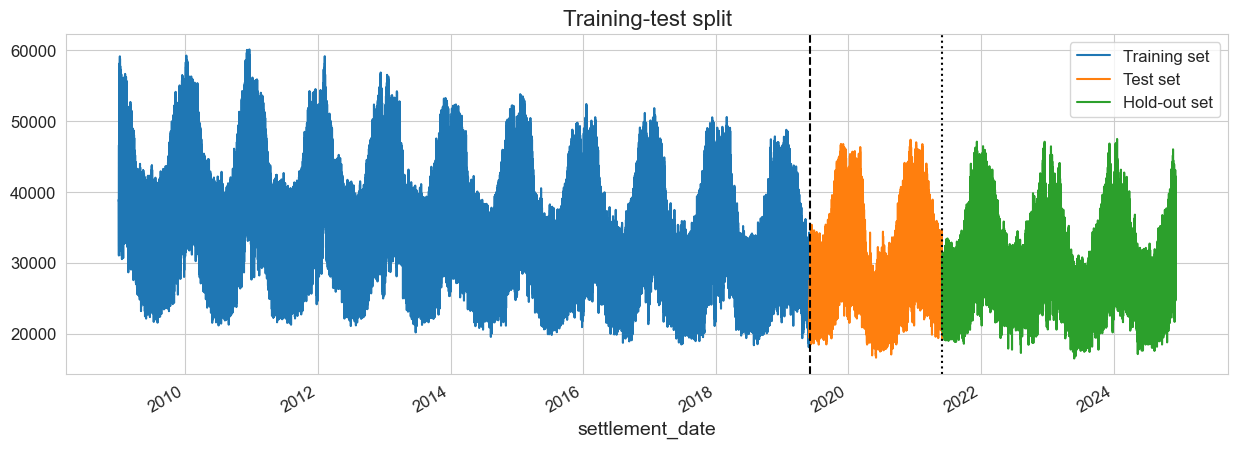

In [60]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [61]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50, 
    random_state=43, 
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);


[0]	validation_0-rmse:7537.22500	validation_1-rmse:8346.85689
[100]	validation_0-rmse:4933.76548	validation_1-rmse:6453.99074
[200]	validation_0-rmse:3758.00700	validation_1-rmse:5413.53964
[300]	validation_0-rmse:3098.69455	validation_1-rmse:4781.77769
[400]	validation_0-rmse:2694.51449	validation_1-rmse:4394.58408
[499]	validation_0-rmse:2442.15493	validation_1-rmse:4151.85893


Une fois le modèle entraîné, il peut être utilisé pour prédire la demande sur l'ensemble de test.

In [63]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

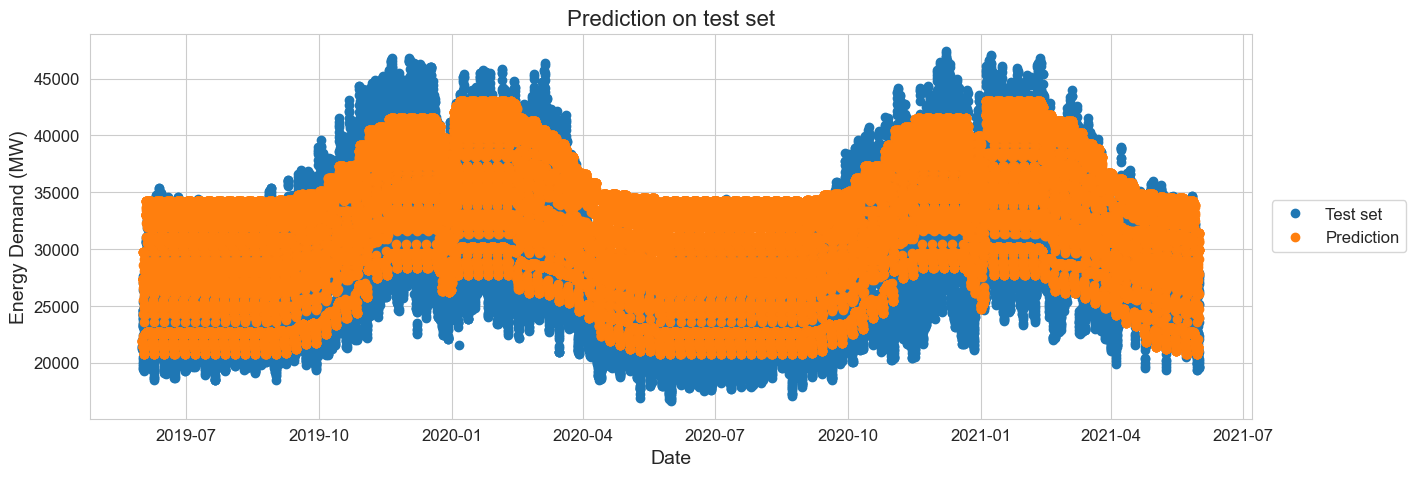

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Concentrons-nous sur une seule semaine pour voir comment les prédictions individuelles se comportent par rapport à l'ensemble de test :



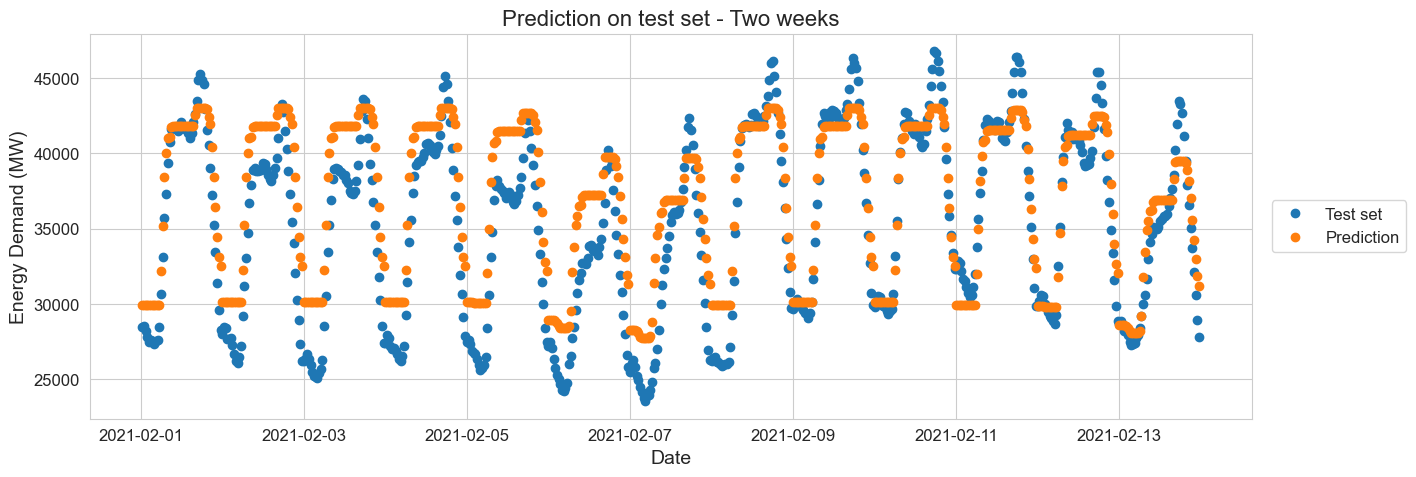

In [66]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Comme on peut le constater, le modèle peine à reproduire les pics et les creux.



In [68]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

Mean Absolute Percentage Error of the simple model is: 11.29
Root Mean Squared Error of the simple models is: 3786.88 MW


### XGBoost avec Cross validation et Grid Search¶


La première étape consiste à créer la partition des données pour la validation croisée.

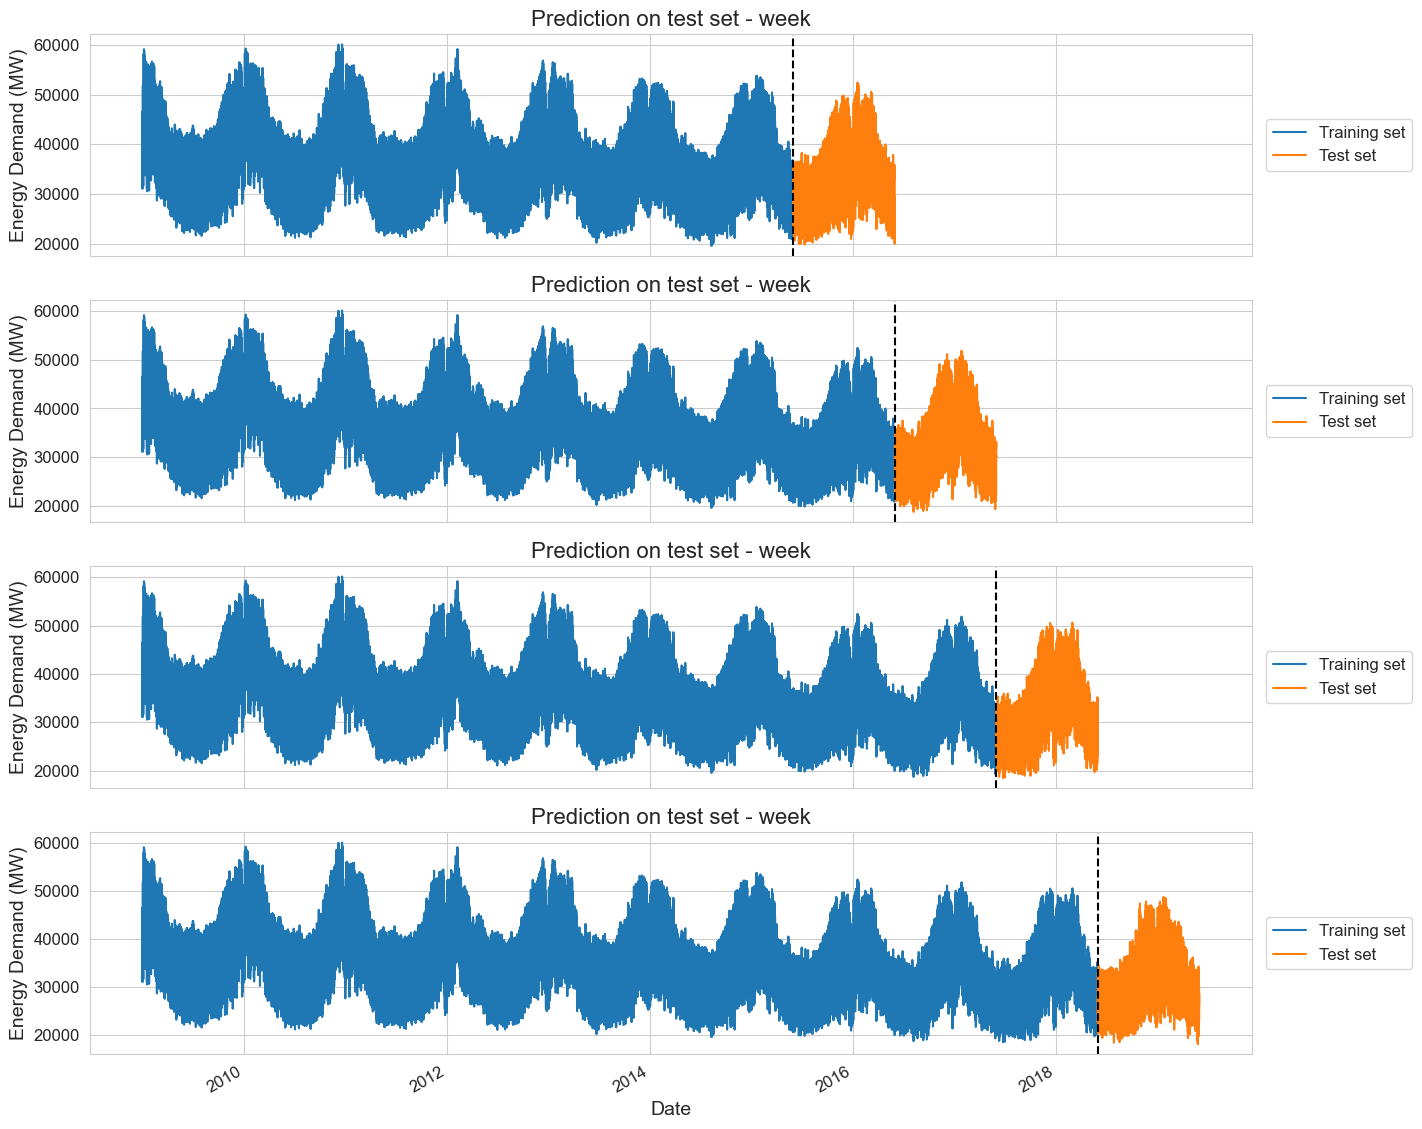

In [71]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [72]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")


In [73]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]

print("🔍 Vérification des données...")
print(f"X_train_cv shape: {X_train_cv.shape}")
print(f"X_hold_out shape: {X_hold_out.shape}")

# ✅ CORRECTION 1: early_stopping_rounds dans le CONSTRUCTEUR
estimator = xgb.XGBRegressor(
    base_score=0.5, 
    booster="gbtree",  
    learning_rate=0.01,
    tree_method="hist",  # ✅ CORRECTION 2: "hist" au lieu de "gpu_hist"
    random_state=43,
    early_stopping_rounds=50,  # ✅ ICI dans le constructeur
    eval_metric="rmse"
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5], 
    "n_estimators": [100, 200, 300],  
    "subsample": [0.8, 0.9],
}

# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    error_score='raise'
)

print("🚀 Lancement de GridSearchCV...")

# ✅ CORRECTION 3: Utiliser eval_set mais SANS early_stopping_rounds
xgb_search.fit(
    X_train_cv, 
    y_train_cv, 
    eval_set=[(X_hold_out, y_hold_out)],  # ✅ eval_set seulement ici
    verbose=100  # ✅ verbose ici
)

print("✅ GridSearchCV terminé!")

🔍 Vérification des données...
X_train_cv shape: (181802, 12)
X_hold_out shape: (61626, 12)
🚀 Lancement de GridSearchCV...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[0]	validation_0-rmse:28819.90807
[99]	validation_0-rmse:10492.08014
[CV 1/4] END max_depth=3, n_estimators=100, subsample=0.8;, score=-11631.954 total time=   1.2s
[0]	validation_0-rmse:28821.82774
[99]	validation_0-rmse:10647.43266
[CV 2/4] END max_depth=3, n_estimators=100, subsample=0.8;, score=-12070.955 total time=   1.2s
[0]	validation_0-rmse:28822.69783
[99]	validation_0-rmse:10710.91888
[CV 3/4] END max_depth=3, n_estimators=100, subsample=0.8;, score=-12224.961 total time=   1.2s
[0]	validation_0-rmse:28824.10705
[99]	validation_0-rmse:10743.06163
[CV 4/4] END max_depth=3, n_estimators=100, subsample=0.8;, score=-11203.016 total time=   1.2s
[0]	validation_0-rmse:28819.80187
[99]	validation_0-rmse:10492.87861
[CV 1/4] END max_depth=3, n_estimators=100, subsample=0.9;, score=-11633.100 total time=

In [74]:
xgb_search.best_params_

{'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

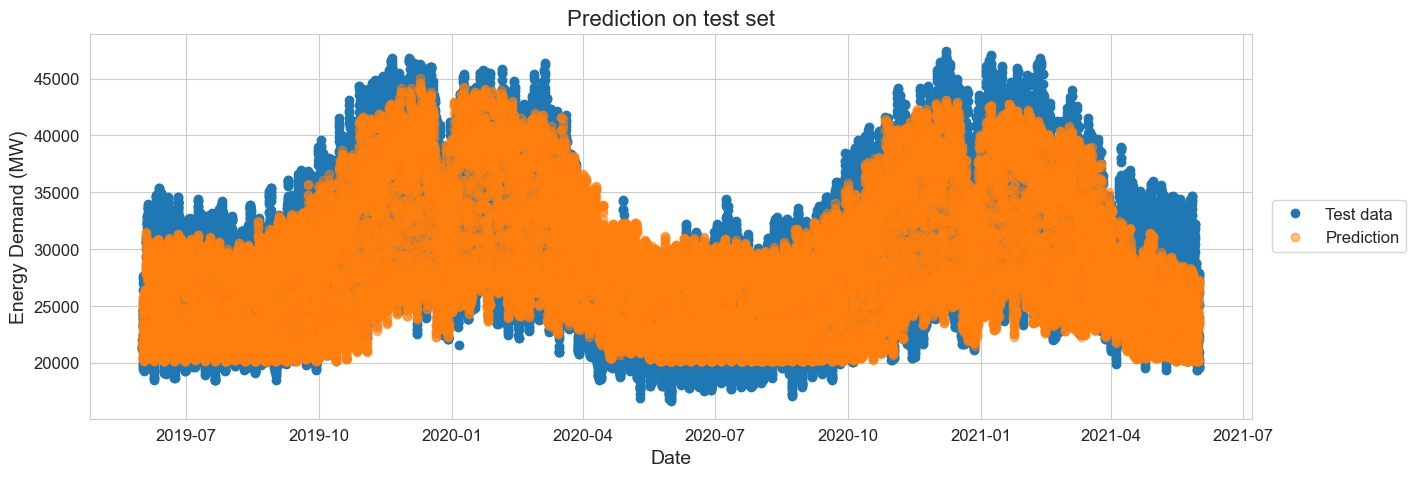

In [75]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

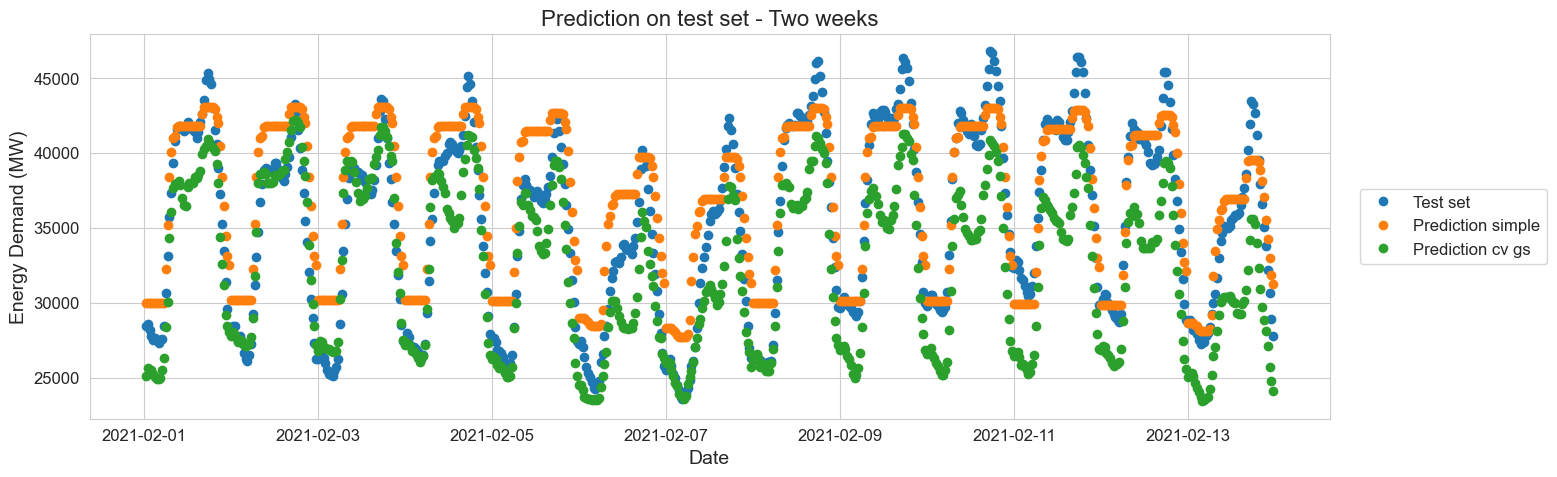

In [76]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Après avoir ajusté certains hyperparamètres, XGBoost parvient mieux à capturer la saisonnalité quotidienne, mais il a du mal à prédire avec précision les pics et les creux.

In [78]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.43
Root Mean Squared Error of the cross-validated model is: 2794.67 MW



Maintenant que les meilleurs paramètres ont été trouvés, le modèle peut être ajusté à l'aide de l'ensemble des données afin de prédire l'avenir.

In [80]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_

# ✅ CORRECTION : Définir early_stopping_rounds dans set_params()
xgb_best.set_params(
    n_jobs=-1,
    early_stopping_rounds=50  # ✅ Ici dans set_params()
)

# ✅ CORRECTION : Retirer early_stopping_rounds de fit()
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100
    # ❌ early_stopping_rounds=50,  # SUPPRIMER cette ligne
)

print("✅ Modèle final entraîné avec succès!")

[0]	validation_0-rmse:33223.77945
[100]	validation_0-rmse:12405.81945
[200]	validation_0-rmse:5050.59754
[299]	validation_0-rmse:2754.66036
✅ Modèle final entraîné avec succès!


In [81]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [82]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

✅ Features temporelles créées avec succès
✅ Lags ajoutés avec succès


settlement_period period_hour  nd  tsd  \
2025-07-03 21:30:00                 44         NaN NaN  NaN   
2025-07-03 22:00:00                 45         NaN NaN  NaN   
2025-07-03 22:30:00                 46         NaN NaN  NaN   
2025-07-03 23:00:00                 47         NaN NaN  NaN   
2025-07-03 23:30:00                 48         NaN NaN  NaN   

                     england_wales_demand  embedded_wind_generation  \
2025-07-03 21:30:00                   NaN                       NaN   
2025-07-03 22:00:00                   NaN                       NaN   
2025-07-03 22:30:00                   NaN                       NaN   
2025-07-03 23:00:00                   NaN                       NaN   
2025-07-03 23:30:00                   NaN                       NaN   

                     embedded_wind_capacity  embedded_solar_generation  \
2025-07-03 21:30:00                     NaN                        NaN   
2025-07-03 22:00:00                     NaN                        NaN   
2025-07-03 22:30:00                     NaN                        NaN   
2025-07-03 23:00:00                     NaN                        NaN   
2025-07-03 23:30:00                     NaN                        NaN   

                     embedded_solar_capacity  non_bm_stor  ...  month  year  \
2025-07-03 21:30:00                      NaN          NaN  ...      7  2025   
2025-07-03 22:00:00                      NaN          NaN  ...      7  2025   
2025-07-03 22:30:00                      NaN          NaN  ...      7  2025   
2025-07-03 23:00:00                      NaN          NaN  ...      7  2025   
2025-07-03 23:30:00                      NaN          NaN  ...      7  2025   

                     week_of_year  hour  is_weekend     lag1     lag2  \
2025-07-03 21:30:00            27    21           0  26993.0  26412.0   
2025-07-03 22:00:00            27    22           0  26036.0  25877.0   
2025-07-03 22:30:00            27    22           0  25201.0  24666.0   
2025-07-03 23:00:00            27    23           0  23691.0  23066.0   
2025-07-03 23:30:00            27    23           0  23143.0  21865.0   

                        lag3  is_future  settlement_date  
2025-07-03 21:30:00  29516.0       True       2025-07-03  
2025-07-03 22:00:00  29170.0       True       2025-07-03  
2025-07-03 22:30:00  28013.0       True       2025-07-03  
2025-07-03 23:00:00  27610.0       True       2025-07-03  
2025-07-03 23:30:00  26711.0       True       2025-07-03  

[5 rows x 32 columns]

On remarque que les dernières lignes du nouveau dataframe correspondent désormais à des dates futures.

Le modèle XGBoost peut donc être utilisé pour générer des prédictions sur ces périodes à venir :

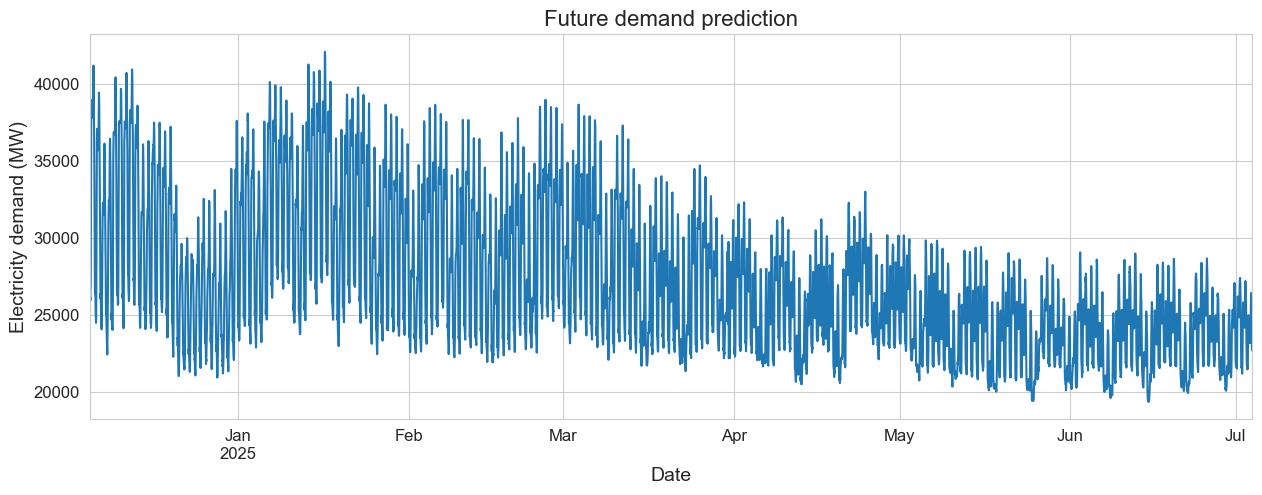

In [84]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

## Linear Trees

In [86]:
%%time
linear_boost = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 350, 
    max_depth = 6,
    random_state = 43,
)

linear_boost.fit(X_train, y_train)

result_frame["pred_linear_boost"] = linear_boost.predict(X_test)

CPU times: total: 17min 32s
Wall time: 8min 53s


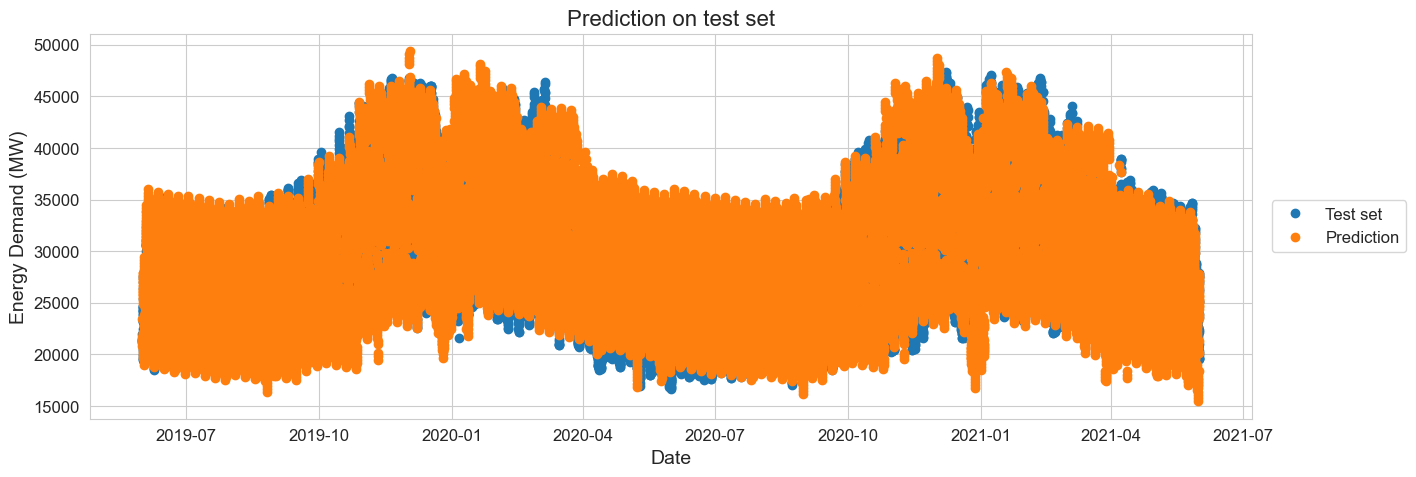

In [87]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_linear_boost"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

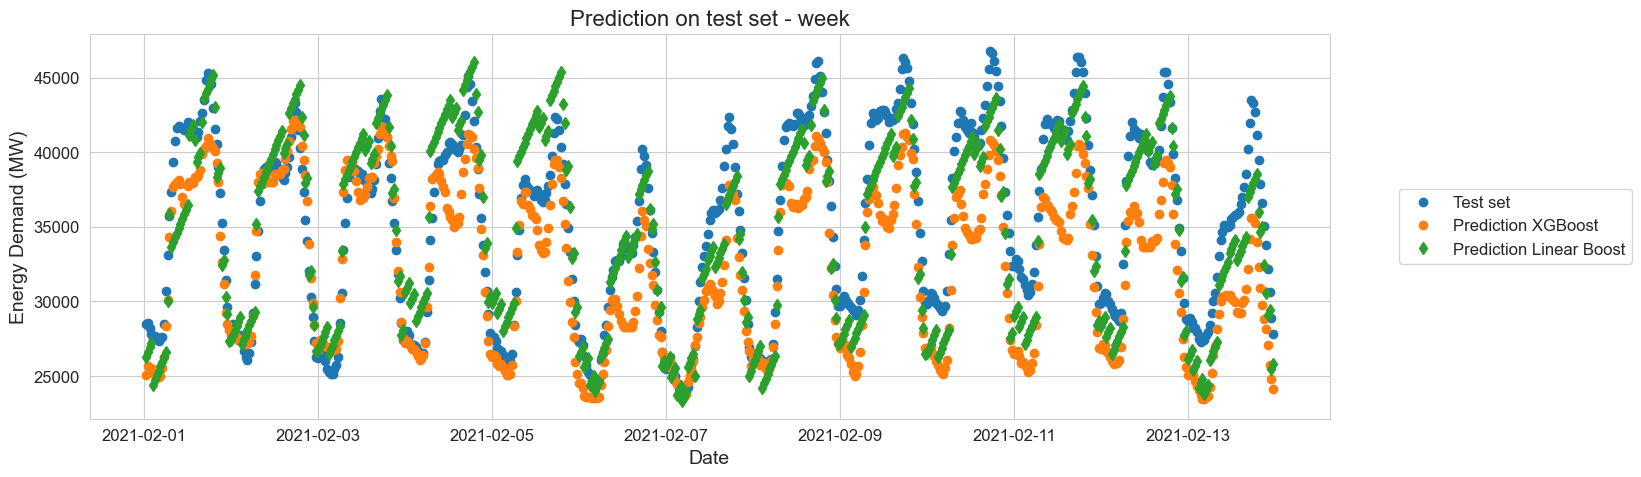

In [88]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction XGBoost",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_linear_boost"
    ],
    "d",
    label="Prediction Linear Boost",
)

ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5))

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Le Linear Boosting semble mieux capturer les pics et les creux, mais il a du mal à modéliser correctement les transitions entre ces variations. On observe ainsi certaines discontinuités, comme celle du 4 février 2021. Cela suggère probablement un sous-apprentissage du modèle sur les données d’entraînement. Malheureusement, même cette version simple nécessite déjà plus de 13 minutes d’exécution.

In [90]:
mape_linear_boost = mean_absolute_percentage_error(
    y_test, result_frame["pred_linear_boost"]
)
rmse_linear_boost = np.sqrt(mean_squared_error(y_test, result_frame["pred_linear_boost"]))

print(
    "Mean Absolute Percentage Error of the Linear Boosted model is: %.2f"
    % mape_linear_boost
) 
print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_linear_boost
)

Mean Absolute Percentage Error of the Linear Boosted model is: 8.49
Root Mean Squared Error of the simple models is: 3045.82 MW


## Prophet

In [92]:
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

La première étape consiste à renommer les colonnes du dataframe pour respecter la notation attendue du modèle.

In [94]:
train_data_prophet = y_train.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
test_data_prophet = y_test.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
hold_out_data_prophet = y_hold_out.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
all_data_prophet = y_all.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})


In [95]:
%%time
prophet_model = Prophet()
prophet_model.fit(train_data_prophet)

np.random.seed(43)
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

CPU times: total: 19.8 s
Wall time: 3min 10s


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2019-06-01 00:00:00  30511.152068  16685.223844  23440.951430  30511.152068   
1 2019-06-01 00:30:00  30511.113382  16184.860958  22715.859295  30511.113382   
2 2019-06-01 01:00:00  30511.074697  15684.890280  22342.035067  30511.074697   
3 2019-06-01 01:30:00  30511.036012  15113.767196  21944.256143  30511.036012   
4 2019-06-01 02:00:00  30510.997326  14755.691516  21617.986701  30510.997326   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  30511.152068   -10420.167331         -10420.167331         -10420.167331   
1  30511.113382   -11004.403586         -11004.403586         -11004.403586   
2  30511.074697   -11464.862479         -11464.862479         -11464.862479   
3  30511.036012   -11885.621705         -11885.621705         -11885.621705   
4  30510.997326   -12324.659652         -12324.659652         -12324.659652   

         daily  ...      weekly  weekly_lower  weekly_upper       yearly  \
0 -5633.999586  ... -626.809233   -626.809233   -626.809233 -4159.358511   
1 -6132.472873  ... -712.710472   -712.710472   -712.710472 -4159.220242   
2 -6505.832460  ... -799.950610   -799.950610   -799.950610 -4159.079410   
3 -6838.233760  ... -888.451920   -888.451920   -888.451920 -4158.936025   
4 -7187.737359  ... -978.132195   -978.132195   -978.132195 -4158.790098   

   yearly_lower  yearly_upper  multiplicative_terms  \
0  -4159.358511  -4159.358511                   0.0   
1  -4159.220242  -4159.220242                   0.0   
2  -4159.079410  -4159.079410                   0.0   
3  -4158.936025  -4158.936025                   0.0   
4  -4158.790098  -4158.790098                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  20090.984737  
1                         0.0                         0.0  19506.709796  
2                         0.0                         0.0  19046.212218  
3                         0.0                         0.0  18625.414307  
4                         0.0                         0.0  18186.337675  

[5 rows x 22 columns]

Enfin, examinons la valeur MAPE :

In [97]:
%%time
mape_prophet_simple = mean_absolute_percentage_error(
    y_test, prophet_predict_df["yhat"]
)
rmse_prophet_simple = np.sqrt(mean_squared_error(y_test, prophet_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the simple Prophet model is: %.2f"
    % mape_prophet_simple
)
print(
    "Root Mean Squared Error of the simple Prophet models is: %.2f MW" % rmse_prophet_simple
)

Mean Absolute Percentage Error of the simple Prophet model is: 9.37
Root Mean Squared Error of the simple Prophet models is: 3262.45 MW
CPU times: total: 15.6 ms
Wall time: 3.49 ms


## Prophète avec des jours fériés

In [99]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

ds              holiday
0 2009-01-01       New Year's Day
1 2009-04-10          Good Friday
2 2009-04-13        Easter Monday
3 2009-05-04              May Day
4 2009-05-25  Spring Bank Holiday

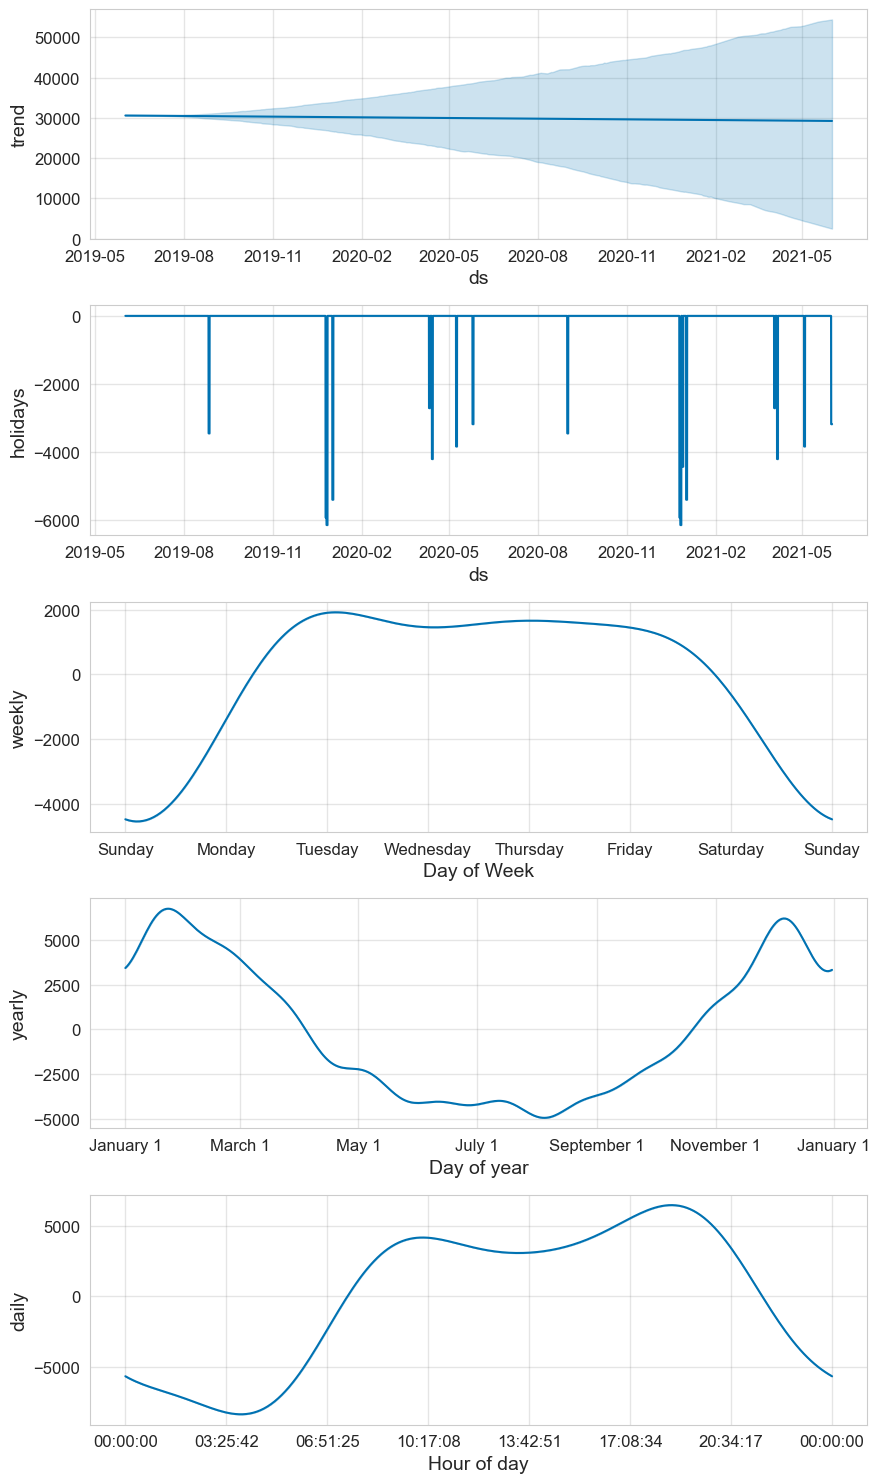

In [100]:
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

np.random.seed(43)
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)
prophet_hol_model.plot_components(prophet_hol_predict_df);

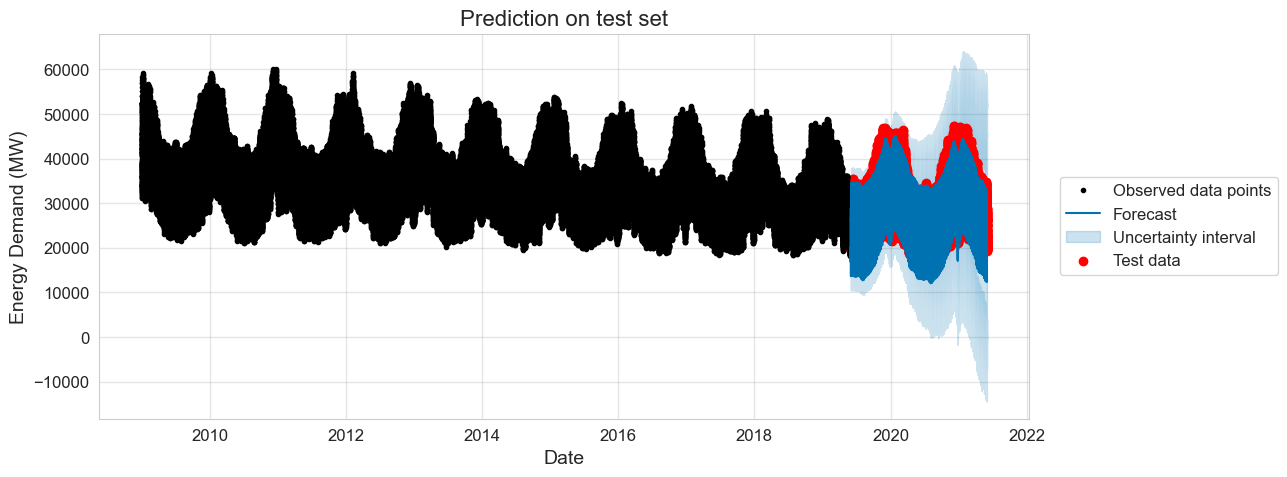

In [101]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_hol_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

La prédiction sur l’ensemble de test apparaît très similaire à celle du modèle Prophet précédent. Cela est logique, puisque le nouveau paramètre n’est censé influencer que les jours fériés. Concentrons-nous donc sur une période comportant plusieurs jours fériés, comme du 23 au 28 décembre (deux jours fériés bancaires), afin de comparer les deux versions du modèle Prophet :

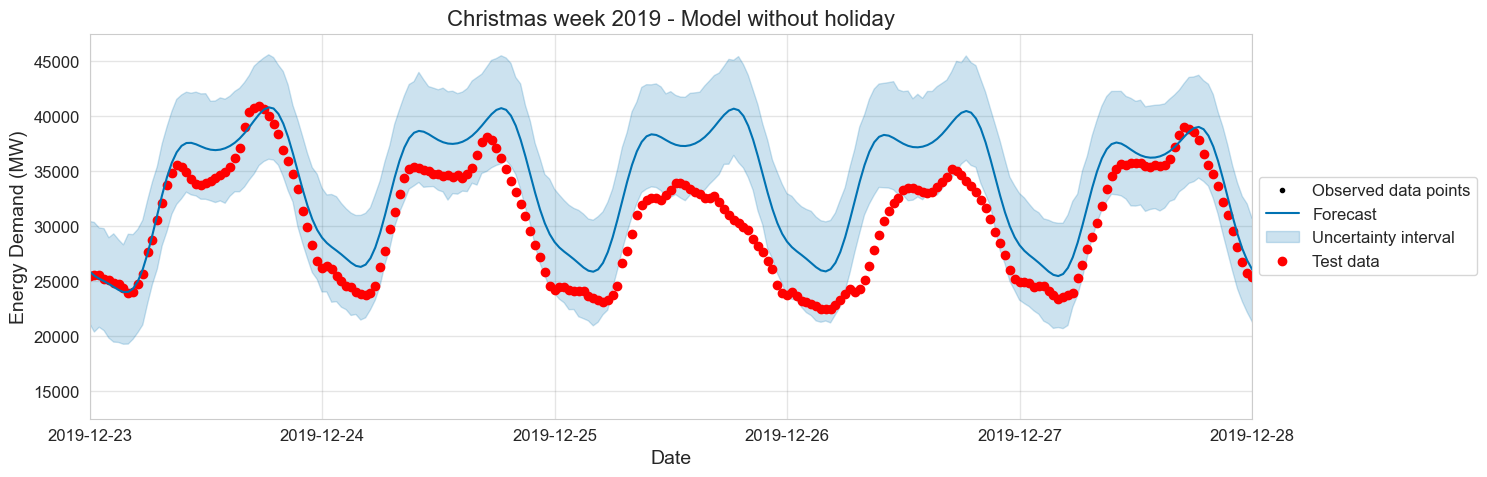

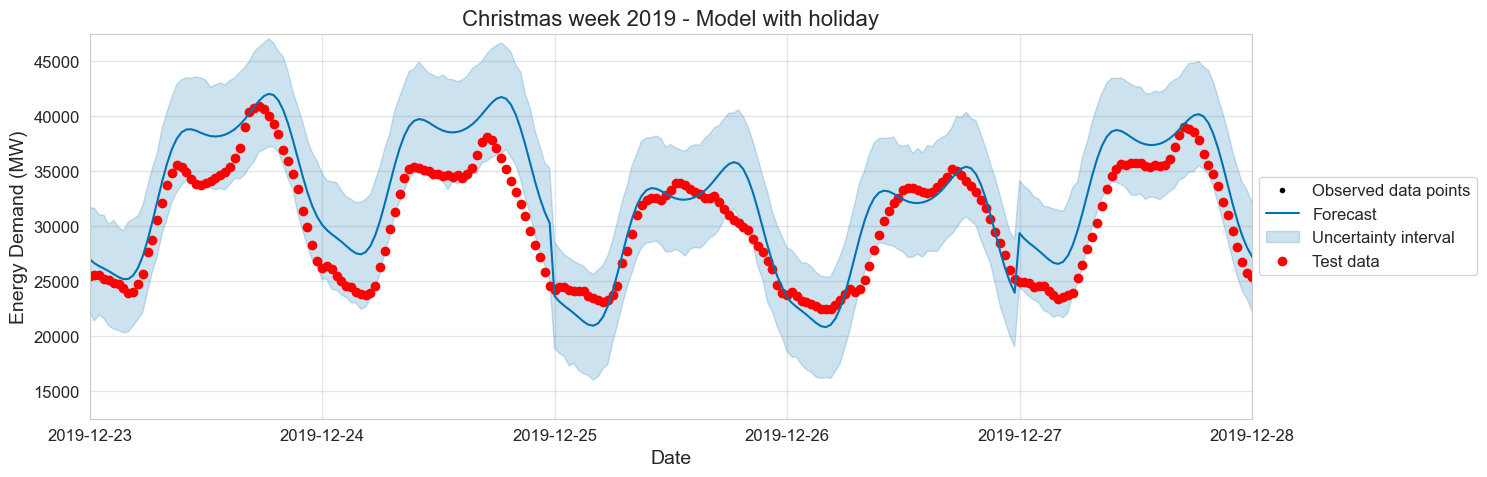

In [103]:
# CORRECTION : Utiliser des objets datetime pour set_xlim()

fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")

# ✅ CORRECTION : Utiliser datetime au lieu de string
ax.set_xlim(left=pd.Timestamp("2019-12-23"), right=pd.Timestamp("2019-12-28"))
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)
ax.set_title("Christmas week 2019 - Model without holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

plt.show()

fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")

# ✅ CORRECTION : Utiliser datetime au lieu de string
ax.set_xlim(left=pd.Timestamp("2019-12-23"), right=pd.Timestamp("2019-12-28"))
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)
ax.set_title("Christmas week 2019 - Model with holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")

plt.show()

La prédiction du second modèle est nettement plus précise, ce qui confirme l’efficacité de cette nouvelle fonctionnalité, en particulier lorsque plusieurs jours fériés sont présents dans les données et que le modèle peut en apprendre les comportements spécifiques.

On remarque également qu’avant et après les jours fériés, la valeur de référence subit des variations brusques (à la hausse ou à la baisse) pour revenir au niveau « hors jours fériés ». Le modèle gagnerait en performance s’il parvenait à ajuster cette transition de manière plus progressive.

In [105]:
mape_prophet_holiday = mean_absolute_percentage_error(
    y_test, prophet_hol_predict_df["yhat"]
)
rmse_prophet_holiday = np.sqrt(mean_squared_error(y_test, prophet_hol_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the holiday Prophet model is: %.2f"
    % mape_prophet_holiday
)
print(
    "Root Mean Squared Error of the Prophet (with holiday) model is: %.2f MW" % rmse_prophet_holiday
)

Mean Absolute Percentage Error of the holiday Prophet model is: 9.35
Root Mean Squared Error of the Prophet (with holiday) model is: 3236.63 MW


## LSTM

In [107]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Bien que les données aient déjà été séparées, les modèles LSTM nécessitent une mise à l’échelle des variables d’entrée pour obtenir des prédictions fiables. Il est donc nécessaire de procéder à une nouvelle division des données, puis d’appliquer l’échelle. Cette seconde séparation est indispensable, car je vais concaténer la variable cible (la demande d’électricité) avec les variables indépendantes, ce qui permet de mettre à l’échelle l’ensemble des données à l’aide d’un unique objet de normalisation.

In [109]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [110]:
# ✅ CORRECTION : Utiliser tf directement au lieu de K
import tensorflow as tf

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compile neural network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))

model.compile(loss=root_mean_squared_error, optimizer="adam")

# ✅ CORRECTION : Les callbacks doivent monitorer des strings, pas des fonctions
monitor_param = "val_loss"  # ✅ Utiliser "val_loss" au lieu de la fonction
mode = "min"

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_param, 
    patience=8, 
    verbose=0, 
    mode=mode
)

checkpoint_save = tf.keras.callbacks.ModelCheckpoint(
    "./models_data/simple_lstm/checkpoint.weights.h5",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
    save_best_only=True  # ✅ Ajouter pour sauvegarder seulement le meilleur
)

reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor_param, 
    factor=0.1, 
    patience=5, 
    verbose=0, 
    mode=mode
)

print("🚀 Début de l'entraînement LSTM...")

# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss],
    verbose=1  # ✅ Changer à 1 pour voir la progression
)

print("✅ Entraînement LSTM terminé!")

🚀 Début de l'entraînement LSTM...
Epoch 1/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1302 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 2/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1044 - val_loss: 0.0898 - learning_rate: 0.0010
Epoch 3/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0968 - val_loss: 0.0870 - learning_rate: 0.0010
Epoch 4/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0922 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0888 - val_loss: 0.0840 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0866 - val_loss: 0.0827 - learning_rate: 0.0010
Epoch 7/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0849 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 8/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0835 - val_loss: 0.0814 - learning_rate: 0.0010
Epoch 9/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - l

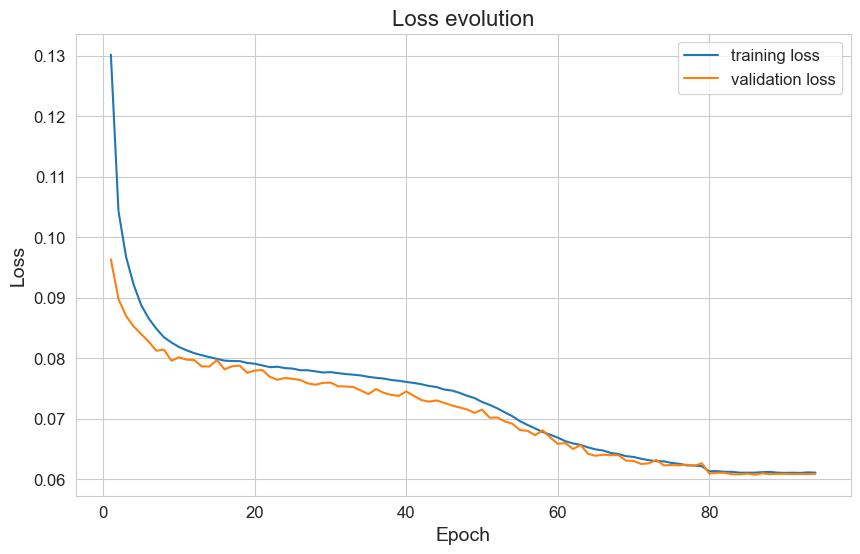

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

Une fois le réseau de neurones entraîné, nous pouvons générer des prédictions sur l’ensemble de test. Comme toutes les données ont été normalisées pour correspondre au modèle, il est nécessaire d’appliquer une transformation inverse aux prédictions avant de les visualiser ou de mesurer leurs performances par rapport aux valeurs réelles de la demande en électricité.

In [113]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_lstm"] = results_lstm[:,-1]

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


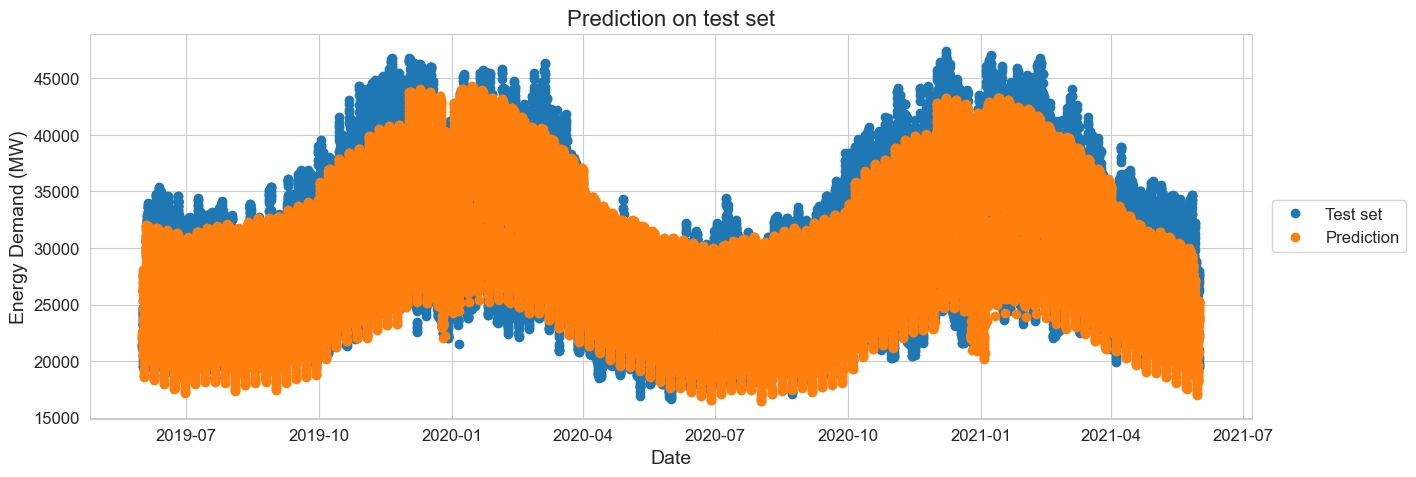

In [114]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

La prédiction globale semble bonne, mais elle peine à identifier correctement les valeurs maximales et minimales. Prenons l'exemple d'une période de deux semaines :

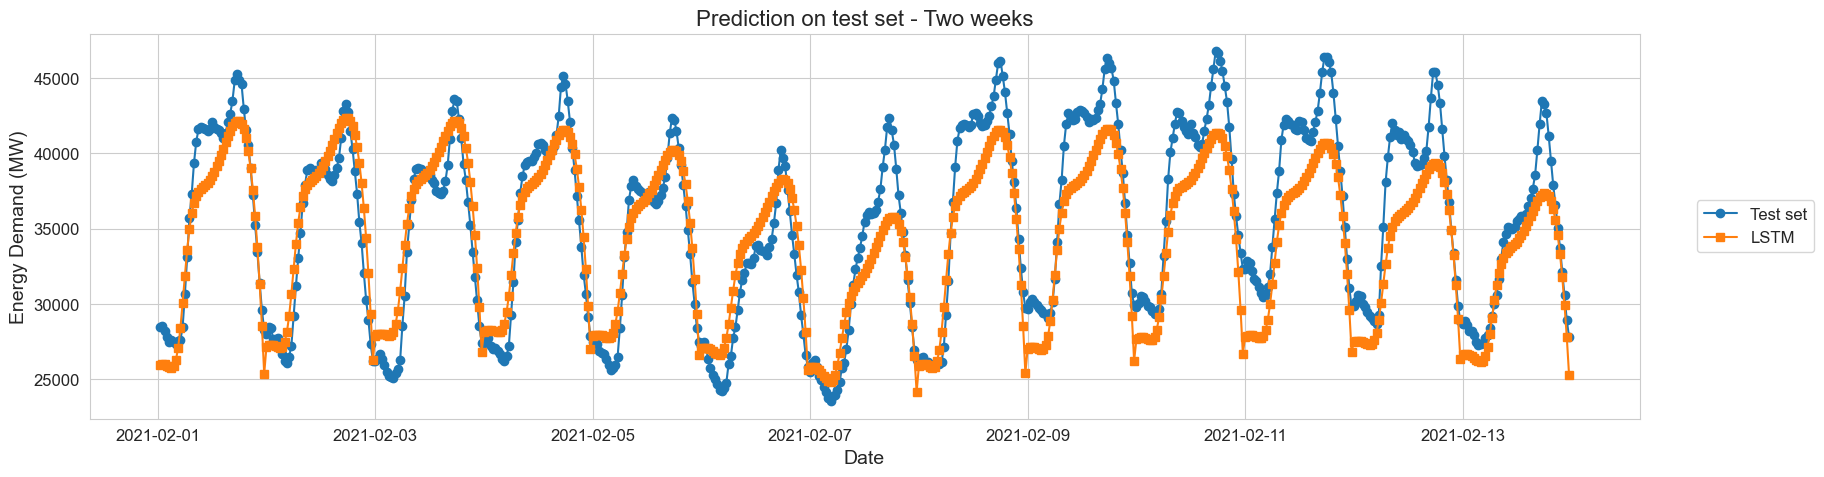

In [116]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

La prédiction reste perfectible : le modèle parvient à capturer la tendance générale - probablement une tendance moyenne - mais la qualité pourrait être améliorée. On remarque notamment que les valeurs prédites du lundi au jeudi (le 1er février 2021 étant un lundi) sont presque identiques, puis qu’elles diminuent progressivement à partir du vendredi pour atteindre leur niveau le plus bas le dimanche.

In [118]:
mape_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Mean Absolute Percentage Error of the LSTM model is: 7.42
Root Mean Squared Error of the LSTM model is: 2726.85 MW


Examinons maintenant les résultats obtenus avec le modèle LSTM profond.

## LSTM profond

In [121]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/deep_lstm/checkpoint.weights.h5",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

Epoch 1/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.1354 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 2/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0939 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 3/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0854 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 4/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0774 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0735 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0716 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 7/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0706 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 8/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0696 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 9/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0689 - val_lo

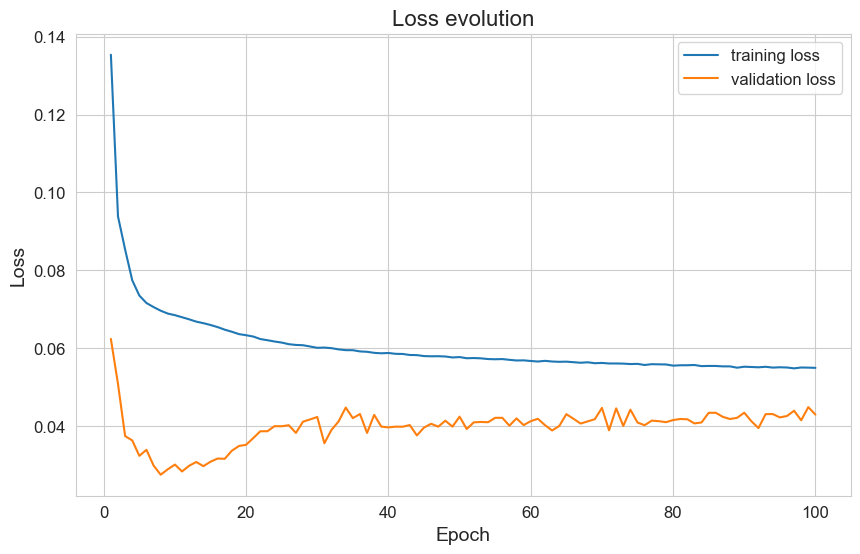

In [122]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

De même que pour le modèle LSTM précédent, la sortie doit subir une transformation inverse.

In [124]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


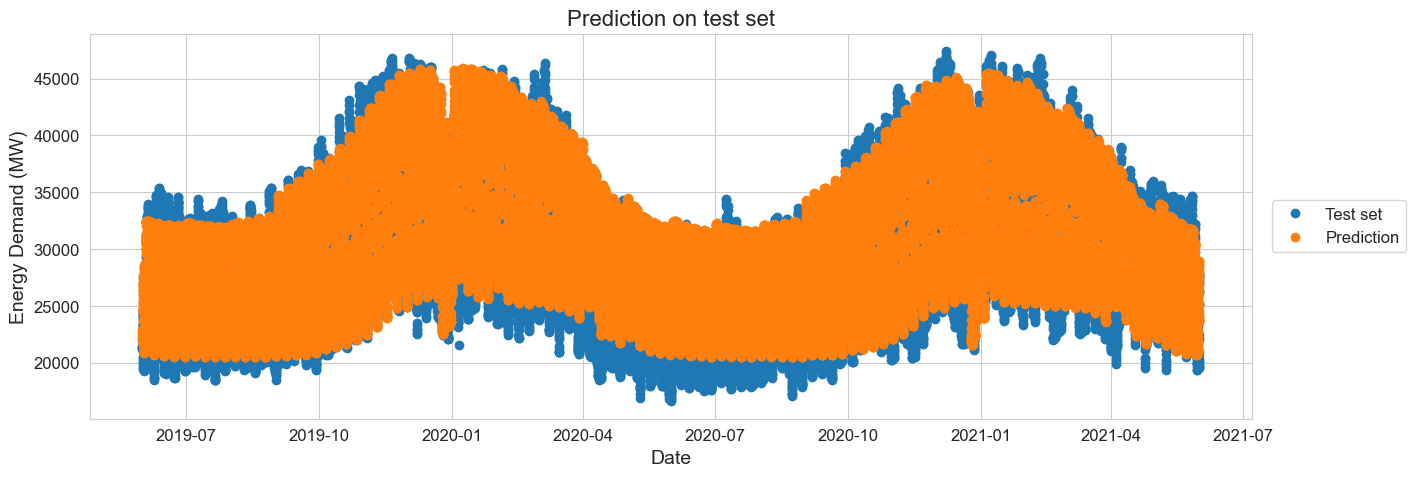

In [125]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Le modèle semble nettement meilleur pour prédire les valeurs maximales quotidiennes, et ses performances s’améliorent durant la période hivernale. En revanche, les prévisions pour l’été sont étonnamment moins bonnes. Une fois encore, les pics sont correctement anticipés, mais les valeurs minimales - particulièrement en 2020 - s’écartent fortement des observations réelles.

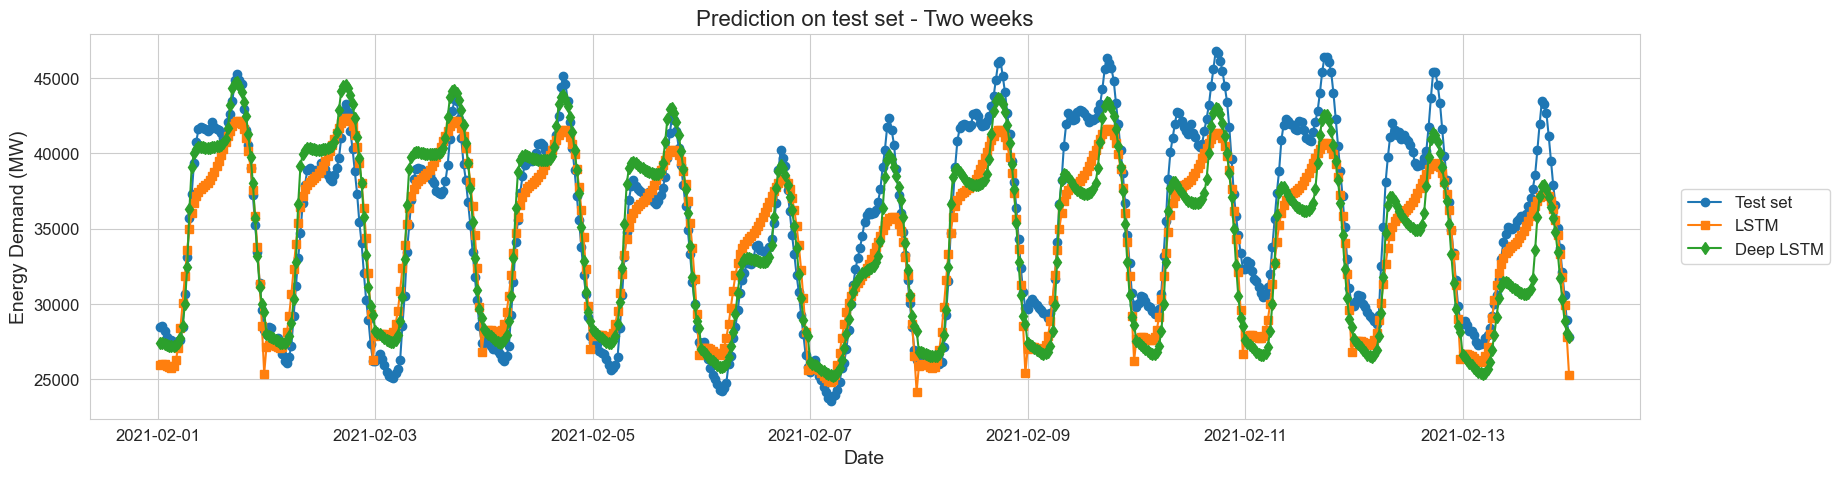

In [127]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

La période de deux semaines présentée ci-dessus montre que le réseau LSTM profond surpasse le LSTM simple. Le motif journalier est presque parfaitement reproduit, même si l’amplitude reste incorrecte.

Cependant, cette période correspond à la saison hivernale, qui - comme mentionné précédemment - semble particulièrement favorable au modèle LSTM profond. Les valeurs de MAPE et de RMSE permettront de confirmer si ses performances globales sont réellement meilleures.

In [129]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Mean Absolute Percentage Error of the deep LSTM model is: 7.58
Root Mean Squared Error of the deep LSTM model is: 2707.82 MW


## GRU

In [131]:
# ✅ AJOUTER LES IMPORTS MANQUANTS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Définir RMSE personnalisé (si pas déjà fait)
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

print("🔄 Création du modèle GRU...")

# Create and compile neural network GRU
model_gru = Sequential()
model_gru.add(GRU(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model_gru.add(Dropout(0.5))
model_gru.add(GRU(128, return_sequences=True))
model_gru.add(Dropout(0.5))
model_gru.add(GRU(32))
model_gru.add(Dropout(0.5))

model_gru.add(Dense(1))
model_gru.compile(loss=root_mean_squared_error, optimizer="adam")

print("✅ Modèle GRU créé et compilé!")

# ✅ CORRECTION : Les callbacks doivent monitorer des strings
monitor_param = "val_loss"  # "val_loss" au lieu de la fonction
mode = "min"

early_stopping = EarlyStopping(
    monitor=monitor_param, 
    patience=8, 
    verbose=0, 
    mode=mode,
    restore_best_weights=True
)

checkpoint_save = ModelCheckpoint(
    "./models_data/deep_gru/checkpoint.weights.h5",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
    save_best_only=True
)

reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, 
    factor=0.1, 
    patience=5, 
    verbose=0, 
    mode=mode
)

print("🚀 Début de l'entraînement GRU...")

# Fit model
history_deep_gru = model_gru.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss],
    verbose=1
)

print("✅ Entraînement GRU terminé!")

🔄 Création du modèle GRU...
✅ Modèle GRU créé et compilé!
🚀 Début de l'entraînement GRU...
Epoch 1/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1364 - val_loss: 0.0707 - learning_rate: 0.0010
Epoch 2/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0954 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 3/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.0874 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 4/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0806 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 5/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0751 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 6/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0727 - val_loss: 0.0349 - learning_rate: 0.0010
Epoch 7/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0715 - val_loss: 0.0381 - learning_rate: 0.0010
Epoch 8/100
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0703 - val_loss: 0.0356 - learning_ra

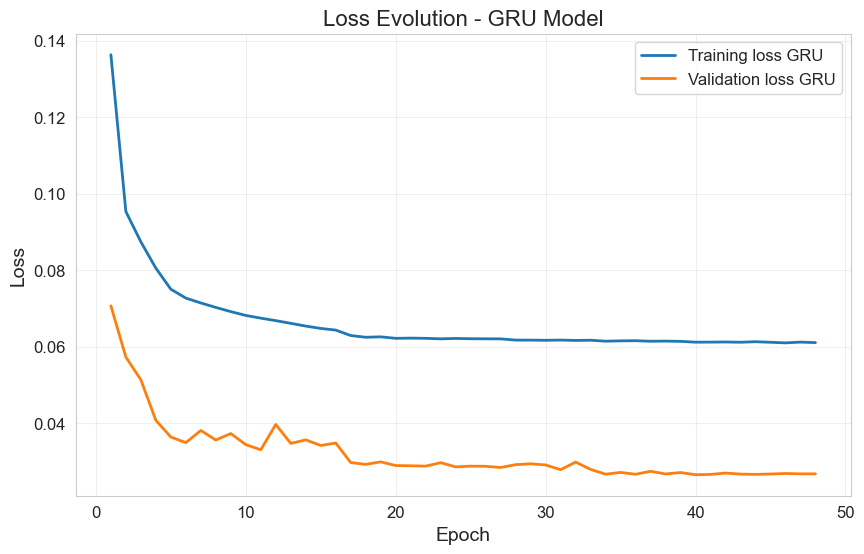

In [132]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_gru.history["loss"]) + 1),
    history_deep_gru.history["loss"],
    label="Training loss GRU",
    linewidth=2
)
ax.plot(
    range(1, len(history_deep_gru.history["loss"]) + 1),
    history_deep_gru.history["val_loss"],
    label="Validation loss GRU", 
    linewidth=2
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss Evolution - GRU Model")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
plt.show()

In [133]:
# Prediction on test set - GRU
pred_deep_gru = model_gru.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in a copy of the original data
results_deep_gru = test_data_keras_s.copy()  # ✅ Ajouter .copy() pour éviter les modifications
results_deep_gru[:, -1] = pred_deep_gru.reshape(pred_deep_gru.shape[0])
results_deep_gru = scaler.inverse_transform(results_deep_gru)

# Store inverse transformed predictions in the result dataframe
result_frame["pred_deep_gru"] = results_deep_gru[:, -1]

print("✅ Prédictions GRU ajoutées au DataFrame!")
print(f"📊 Shape des prédictions GRU: {pred_deep_gru.shape}")

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
✅ Prédictions GRU ajoutées au DataFrame!
📊 Shape des prédictions GRU: (35084, 1)


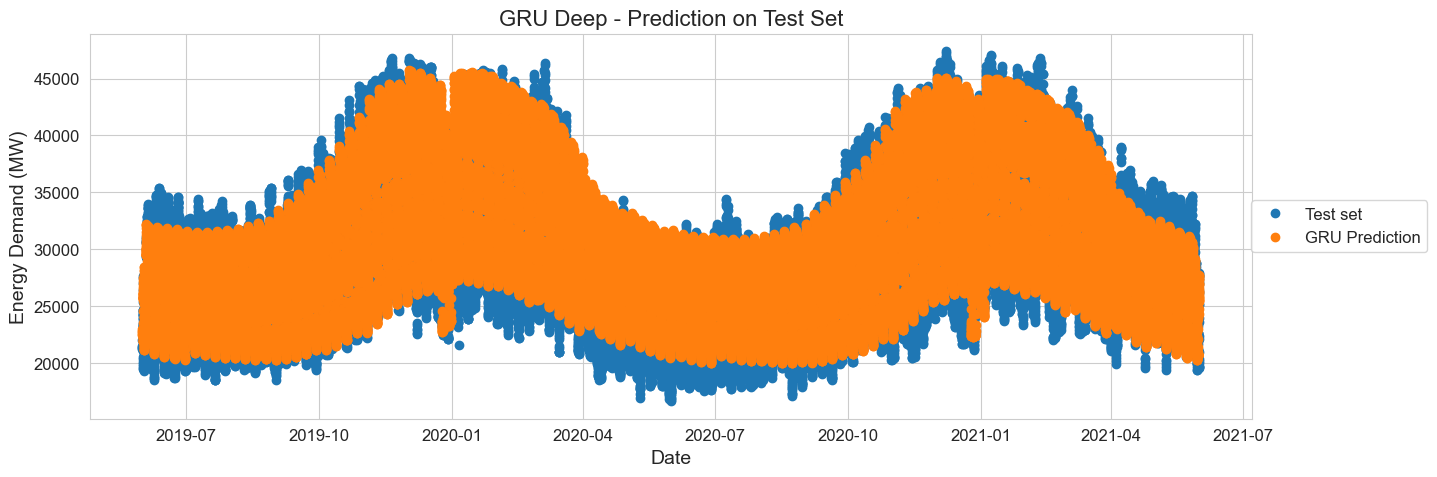

In [134]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_gru"], "o", label="GRU Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("GRU Deep - Prediction on Test Set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
plt.show()

Le modèle GRU profond parvient à reproduire correctement la tendance générale et à prédire les valeurs maximales, surtout en hiver. Cependant, ses prévisions restent trop lissées et manquent de précision pour les variations quotidiennes. Les valeurs minimales, en particulier durant l’année 2020, s’éloignent nettement des données réelles.

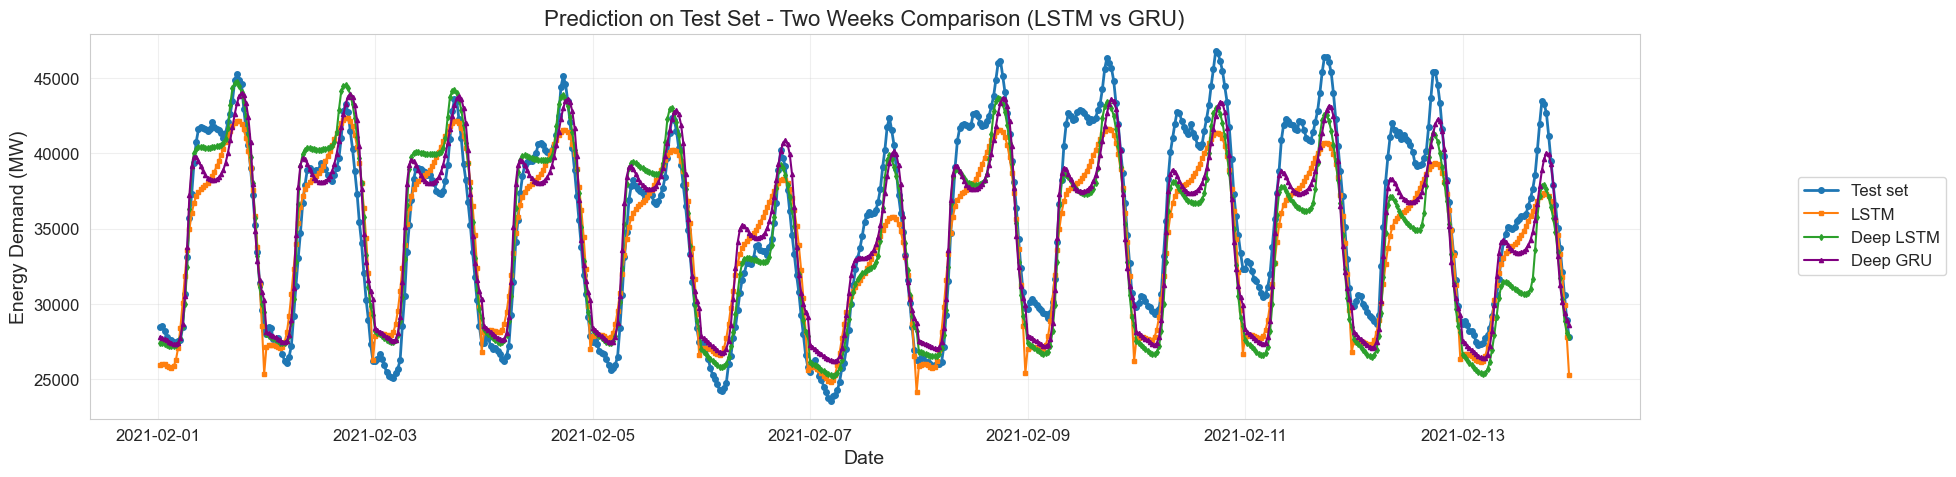

In [136]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
    linewidth=2,
    markersize=4
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
    linewidth=1.5,
    markersize=3
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM", 
    linewidth=1.5,
    markersize=3
)

# ✅ AJOUT DU GRU
ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_gru"
    ],
    "-^",
    label="Deep GRU",
    linewidth=1.5,
    markersize=3,
    color='purple'
)

ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5))

ax.set_title("Prediction on Test Set - Two Weeks Comparison (LSTM vs GRU)")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date")
ax.grid(True, alpha=0.3)
plt.show()

In [137]:
# Métriques pour GRU Deep
mape_deep_gru = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_gru"]
)

rmse_deep_gru = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_gru"]))

print(
    "Mean Absolute Percentage Error of the deep GRU model is: %.2f" % mape_deep_gru
)

print(
    "Root Mean Squared Error of the deep GRU model is: %.2f MW" % rmse_deep_gru
)

Mean Absolute Percentage Error of the deep GRU model is: 7.30
Root Mean Squared Error of the deep GRU model is: 2598.92 MW


## Résumé des résultats et principaux enseignements

In [139]:
summary_df = pd.DataFrame(
    {
        "XGBoost - Simple": [mape_xgboost_simple, rmse_xgboost_simple],
        "XGBoost - CV & GS": [mape_xgboost_cv, rmse_xgboost_cv],
        "Linear Boost": [mape_linear_boost, rmse_linear_boost],
        "Prophet - Simple": [mape_prophet_simple, rmse_prophet_simple],
        "Prophet - Holiday": [mape_prophet_holiday, rmse_prophet_holiday],
        "LSTM": [mape_lstm, rmse_lstm],
        "Deep LSTM": [mape_deep_lstm, rmse_deep_lstm],
        "Deep GRU": [mape_deep_gru, rmse_deep_gru],  
        "Metric": ["MAPE", "RMSE"]
    }
)

summary_df.set_index("Metric", inplace=True)

# Affichage formaté
styled_df = summary_df.style.format('{:.2f}')
styled_df

#### XGBoost Simple :
Obtient un MAPE de 11,29% et un RMSE de 3786,88, montrant des performances correctes mais perfectibles. Comme souvent avec XGBoost, quelques lignes de code suffisent pour obtenir des résultats décents, ce qui explique sa popularité.

### XGBoost avec Validation Croisée et Grid Search : 
Démontre l'impact crucial de l'optimisation hyperparamétrique : le MAPE chute à 7,43% et le RMSE à 2794,67. Cette amélioration spectaculaire confirme que XGBoost bien réglé reste un compétiteur sérieux.

### Linear Boost :
Se positionne comme une alternative intéressante avec un MAPE de 8,49% et RMSE de 3045,82. Bien que légèrement moins performant que XGBoost optimisé, il résout certains problèmes spécifiques aux arbres de décision pour les séries temporelles.

### Prophet (simple et avec holidays) : 
Montre des performances similaires autour de 9,35-9,37% de MAPE. L'ajout des jours fériés n'apporte qu'une amélioration marginale, suggérant que d'autres facteurs saisonniers dominent la dynamique des données.

### LSTM :
Marque un saut significatif avec 7.42% de MAPE et 2726.85 de RMSE, dépassant XGBoost optimisé. Cette performance confirme la capacité des réseaux récurrents à capturer les dépendances temporelles complexes.

### Deep LSTM :
émerge comme le champion incontesté avec le MAPE le plus bas (7.58%) et le RMSE le plus bas (2707.82). Son architecture profonde lui permet de modéliser des patterns temporels sophistiqués que les autres approches ne capturent pas complètement.

### Deep GRU :
Obtient des performances très proches (7.30% MAPE, 2598.92 RMSE), confirmant l'efficacité des architectures neuronales récurrentes pour cette tâche.

## Recommandation Finale

#### Deep GRU
Est clairement le meilleur choix pour la performance pure. Son architecture spécialisée pour les séquences temporelles et sa profondeur lui permettent d'atteindre les meilleures métriques sur les deux critères.

#### LSTM et Deep LSTM 
Constituent d'excellentes alternatives, offrant un compromis entre performance et complexité. Le GRU peut être préféré pour son entraînement généralement plus rapide.

#### XGBoost avec CV & GS 
Reste pertinent pour ceux qui privilégient la rapidité d'exécution et l'interprétabilité tout en maintenant de bonnes performances.


La supériorité des approches neuronales (LSTM, GRU) dans ce benchmark suggère que la nature séquentielle de vos données bénéficie particulièrement des architectures conçues pour capturer les dépendances temporelles à long terme.